# Материалы
- Ссылка на презентацию: https://disk.yandex.ru/i/7NKVHtPCbCNLnQ
- Ссылка на дашборд:  https://public.tableau.com/views/banc_for_project/Dashboard1?:language=en-US&:display_count=n&:origin=viz_share_link



## Изучение данных

In [1]:
# подключение библиотек, необходимых в работе
import pandas as pd  
import numpy as np  

# импорт библиотек для построения графиков
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# импорт библиотек для построения моделей и расчета метрик
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import roc_auc_score, f1_score, recall_score, precision_score

# импорт библиотек для проведения статистических тестов
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import mannwhitneyu, ttest_ind

In [2]:
# чтение файла с данными и сохранение его в переменную
df = pd.read_csv('bank_new_dataset.csv')

In [3]:
# функция для первичного просмотра данных в файлах, вывода общей информации 
def show_info_and_head(df, table_name):
    # получение общей информации о данных в таблице
    title = 'Получение общей информации о данных в таблице ' + table_name
    print(title)
    print('=' * len(title))
    print(df.info())
    # вывод первых пяти строк для ознакомления с данными
    print('\nВывод первых пяти строк для ознакомления с данными', table_name)
    display(df.sample(5))
    # вывод количества пропусков по столбцам
    # (показывает сумму пропусков, долю пропусков в % и кол-во уникальных значений в столбцах)
    print('\nПропуски и уникальные значения (без учета пропусков):')
    display(pd.concat([df.isna().sum().rename('nan_count'), 
                       df.isna().mean().rename('nan_percent'),
                       df.nunique().rename('unique_values')], 
                      axis=1).style.format({'nan_percent' : '{:.2%}'})) 
    # вывод кол-ва дубликатов в таблице
    print()
    print('Число явных дубликатов в', table_name, ':', df.duplicated().sum()) 
       
show_info_and_head(df, 'df')

Получение общей информации о данных в таблице df
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   userid         10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            10000 non-null  int64  
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  salary         10000 non-null  float64
 11  churn          10000 non-null  int64  
dtypes: float64(3), int64(7), object(2)
memory usage: 937.6+ KB
None

Вывод первых пяти строк для ознакомления с данными df


userid  score       city gender  age  equity     balance  products  \
4305   79088  812.0  Ярославль      Ж   43       5   743148.73         2   
4257  163913  747.0     Ростов      Ж   34       5   513199.91         2   
4521   49068  724.0  Ярославль      М   34       0         NaN         1   
793   147609  866.0  Ярославль      М   34       5  1078468.80         2   
4600  232125  650.0     Ростов      М   27       0         NaN         1   

      credit_card  last_activity     salary  churn  
4305            1              0   46397.48      0  
4257            1              0   39628.12      0  
4521            1              1  380869.25      0  
793             0              1  248223.18      1  
4600            1              1   64577.35      0


Пропуски и уникальные значения (без учета пропусков):



Число явных дубликатов в df : 0


Для исследования получен датасет, в котором 10000 уникальных записей по клиентам банка и 12 различных характеристик. 

В значениях столбца 'balance' есть пропуски, которые необходимо проанализировать и по возможности заполнить, так как их количество очень большое (почти 23% всех данных).

Тип данных для значения 'score' изменю на целочисленное для удобства.

Для избежание возникновения сложностей при обращении к столбцам из таблицы - названия колонок приведу к одному виду: стилю snake_case.

В данных по доходам клиентов 'salary' 9997 уникальных записей из 10000, скорее всего есть неявные дубликаты - проверю их.


## Предобработка данных

### Изменение стиля заголовков

In [4]:
# переименование столбца
df = df.rename(columns={'userid': 'user_id'})
# вывод названий столбцов на экран для проверки
df.columns

Index(['user_id', 'score', 'city', 'gender', 'age', 'equity', 'balance',
       'products', 'credit_card', 'last_activity', 'salary', 'churn'],
      dtype='object')

### Изменение типов данных

In [5]:
# изменение типа данных на 'int'
df['score'] = df['score'].astype('int')

### Работа с пропусками и дубликатами

В данных по заработной плате клиента уникальных значений 9997 из 10000, значит есть одинаковые значения, проверю их:

In [6]:
salary = df['salary']
# вывод дублирующих записей доходов 
df[salary.isin(salary[salary.duplicated()])].sort_values('salary')

user_id  score       city gender  age  equity    balance  products  \
1937   103039    832    Рыбинск      Ж   37       2  430220.82         2   
4205   189762    861     Ростов      Ж   60       3  599546.80         2   
2829    71651    831  Ярославль      М   50       5  560145.71         2   
7931   193528    751    Рыбинск      Ж   30       2  820572.71         3   
8886    25434    772  Ярославль      М   53       2  335295.37         2   
9153   259847    947  Ярославль      М   30       5  393215.11         2   

      credit_card  last_activity     salary  churn  
1937            1              1   49742.87      0  
4205            1              1   49742.87      0  
2829            1              1  108250.17      0  
7931            1              0  108250.17      0  
8886            1              1  176348.18      0  
9153            1              0  176348.18      0

Данные дубликаты никак не связаны между собой (это разные люди из разных городов и возрастов). Скорее всего такие одинаковые суммы доходов возникли из-за заполнения данных с помощью модели машинного обучения, которое применялось при  формирования этих значений в датасете.

Посмотрю на пропуски в столбце balance:

In [7]:
# вывод данных с пропусками
df.loc[df['balance'].isna()]

user_id  score       city gender  age  equity  balance  products  \
408    261907    734    Рыбинск      Ж   79       3      NaN         0   
1439   154581    662    Рыбинск      М   32       0      NaN         1   
1442    92746    687    Рыбинск      М   31       0      NaN         1   
1443   161908    664  Ярославль      Ж   29       0      NaN         1   
1453   155767    703  Ярославль      Ж   33       0      NaN         1   
...       ...    ...        ...    ...  ...     ...      ...       ...   
9993   248568    720    Рыбинск      Ж   43       0      NaN         2   
9994   145758    671  Ярославль      Ж   40       0      NaN         1   
9995   186605    693    Рыбинск      М   42       0      NaN         2   
9996   204842    655  Ярославль      М   27       0      NaN         1   
9999   128656    698  Ярославль      Ж   37       0      NaN         1   

      credit_card  last_activity     salary  churn  
408             0              0   25063.96      1  
1439            1              0   82847.95      0  
1442            1              1  133324.89      0  
1443            1              0  120174.24      0  
1453            1              0  171038.71      0  
...           ...            ...        ...    ...  
9993            1              0  241225.29      0  
9994            0              0  169445.35      0  
9995            1              1  221661.10      0  
9996            1              0  144948.73      0  
9999            1              1  255439.00      0  

[2295 rows x 12 columns]

Очень похоже, что в основном все клиенты с пропусками не попадали в отток, проверю:

In [8]:
# вывод не попадающих в отток с пропусками в балансе
df.loc[(df['balance'].isna()) & (df['churn']==0)]

user_id  score       city gender  age  equity  balance  products  \
1439   154581    662    Рыбинск      М   32       0      NaN         1   
1442    92746    687    Рыбинск      М   31       0      NaN         1   
1443   161908    664  Ярославль      Ж   29       0      NaN         1   
1453   155767    703  Ярославль      Ж   33       0      NaN         1   
1454   122713    708  Ярославль      Ж   33       0      NaN         1   
...       ...    ...        ...    ...  ...     ...      ...       ...   
9993   248568    720    Рыбинск      Ж   43       0      NaN         2   
9994   145758    671  Ярославль      Ж   40       0      NaN         1   
9995   186605    693    Рыбинск      М   42       0      NaN         2   
9996   204842    655  Ярославль      М   27       0      NaN         1   
9999   128656    698  Ярославль      Ж   37       0      NaN         1   

      credit_card  last_activity     salary  churn  
1439            1              0   82847.95      0  
1442            1              1  133324.89      0  
1443            1              0  120174.24      0  
1453            1              0  171038.71      0  
1454            1              0  159013.27      0  
...           ...            ...        ...    ...  
9993            1              0  241225.29      0  
9994            0              0  169445.35      0  
9995            1              1  221661.10      0  
9996            1              0  144948.73      0  
9999            1              1  255439.00      0  

[2291 rows x 12 columns]

Кроме 4х записей - все это неотточные клиенты. Посмотрю, кто из тех, где есть пропуски, попал в отток:

In [9]:
# вывод попадающих в отток с пропусками в балансе
df.loc[(df['balance'].isna()) & (df['churn']==1)]

user_id  score       city gender  age  equity  balance  products  \
408    261907    734    Рыбинск      Ж   79       3      NaN         0   
3817   187149    707  Ярославль      М   24       0      NaN         3   
8216   182044    725  Ярославль      М   30       0      NaN         3   
9939   126027    718    Рыбинск      М   37       0      NaN         3   

      credit_card  last_activity     salary  churn  
408             0              0   25063.96      1  
3817            1              0   94091.11      1  
8216            1              0  157069.20      1  
9939            1              0  196941.60      1

Похоже на то, что не заполнился баланс у клиентов, которые либо попали в отток, либо имели количество используемых продуктов банка менее 3х, либо не имели собственности:

In [10]:
# вывод пропущенных значений по условию
df.loc[(df['balance'].isna()) & ((df['products']<3) | (df['equity']==0) | (df['churn']==0))]

user_id  score       city gender  age  equity  balance  products  \
408    261907    734    Рыбинск      Ж   79       3      NaN         0   
1439   154581    662    Рыбинск      М   32       0      NaN         1   
1442    92746    687    Рыбинск      М   31       0      NaN         1   
1443   161908    664  Ярославль      Ж   29       0      NaN         1   
1453   155767    703  Ярославль      Ж   33       0      NaN         1   
...       ...    ...        ...    ...  ...     ...      ...       ...   
9993   248568    720    Рыбинск      Ж   43       0      NaN         2   
9994   145758    671  Ярославль      Ж   40       0      NaN         1   
9995   186605    693    Рыбинск      М   42       0      NaN         2   
9996   204842    655  Ярославль      М   27       0      NaN         1   
9999   128656    698  Ярославль      Ж   37       0      NaN         1   

      credit_card  last_activity     salary  churn  
408             0              0   25063.96      1  
1439            1              0   82847.95      0  
1442            1              1  133324.89      0  
1443            1              0  120174.24      0  
1453            1              0  171038.71      0  
...           ...            ...        ...    ...  
9993            1              0  241225.29      0  
9994            0              0  169445.35      0  
9995            1              1  221661.10      0  
9996            1              0  144948.73      0  
9999            1              1  255439.00      0  

[2295 rows x 12 columns]

Предположение оказалось верным. По проблемам в заполнении данных стоит сообщить коллегам. Так как заполнять баланс каким-либо средним или медианным значением некорректно (тут могут быть какие угодно цифры), а удаление 23% данных может сильно повлиять на исследование, то для удобства анализа у таких клиентов я проставлю в балансе -1 (заполнение каким-либо значением еще и необходимо, если в дальнейшем понадобится чистить выбросы + чтобы в дальнейшем была возможность проанализировать этих клиентов на графиках). Предварительно проверю, что распределение данных при этом у меня не "поехало":

In [11]:
#функция для построения графиков типа hist
def make_hist(df, y, bins, title):
    df.plot(y=y, kind='hist', bins=bins, grid=True, title=title, legend = False, figsize=(8,5))
    plt.ylabel('Частота распределения');   

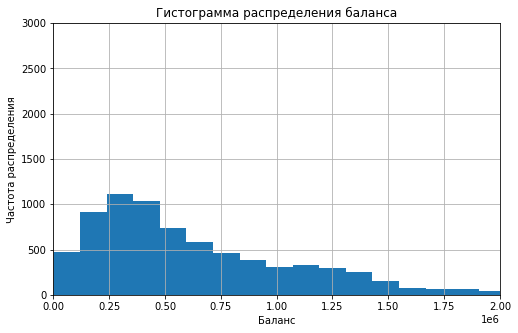

In [12]:
#построение гистограммы распределения значений баланса
make_hist(df, y='balance', bins=1000, title='Гистограмма распределения баланса')
plt.xlim(-2, 2000000)
plt.ylim(0, 3000)
plt.xlabel('Баланс');

In [13]:
# заполнение пропущенных значений
df['balance'] = df['balance'].fillna(-1)

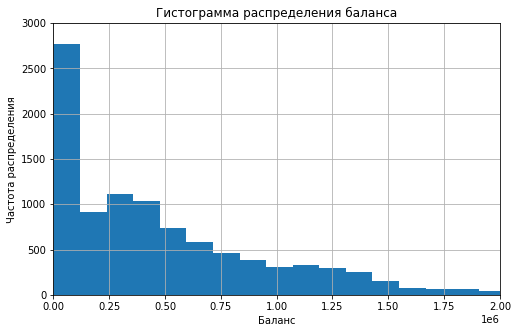

In [14]:
#построение гистограммы распределения значений баланса
make_hist(df, y='balance', bins=1000, title='Гистограмма распределения баланса')
plt.xlim(-2, 2000000)
plt.ylim(0, 3000)
plt.xlabel('Баланс');

В распределении появился пик около нуля, в остальном распределение данных не изменилось. 

### Выбросы и аномалии

Проверю данные на аномальные значения и выбросы (значения принимающие 0 или 1 смотреть бессмыслено, возьму только некоторые где возможны аномалии):

In [15]:
df[['score', 'age', 'equity', 'balance', 'products', 'salary']].describe().T

count           mean           std     min         25%  \
score     10000.0     804.542200  7.813665e+01   638.0    747.7500   
age       10000.0      42.837100  1.212851e+01    18.0     34.0000   
equity    10000.0       2.627600  1.980836e+00     0.0      0.0000   
balance   10000.0  638763.327039  1.772873e+06    -1.0  65083.9175   
products  10000.0       1.966600  6.765576e-01     0.0      2.0000   
salary    10000.0  147866.957391  1.393886e+05  2546.3  75251.9000   

                 50%          75%           max  
score        813.000     864.0000  1.000000e+03  
age           40.000      51.0000  8.600000e+01  
equity         3.000       4.0000  9.000000e+00  
balance   376186.165  804501.0775  1.191136e+08  
products       2.000       2.0000  5.000000e+00  
salary    119658.105  174500.5425  1.395064e+06

Все значения вполне адекватные, кроме того, что минимум у products=0. Хотя бы один банковский продукт, но должен быть, иначе человек не был бы клиентом банка. Посмотрю, клиентов, у которых нет ни одного банковского продукта:

In [16]:
# отбор значений по условию
df.query('products<1')

user_id  score     city gender  age  equity  balance  products  \
408   261907    734  Рыбинск      Ж   79       3     -1.0         0   

     credit_card  last_activity    salary  churn  
408            0              0  25063.96      1

Так как таких данных всего одна строчка, то удалю ее (это не повлияет на дальнейший анализ):

In [17]:
# сохранение датасета по условию
df = df.query('products>=1').copy()
# проверка размерности
df.shape

(9999, 12)

Есть сильный разброс в значениях баланса и заработной платы, построю для них boxplot (ящики с усами) и посмотрю на аномальные значения:

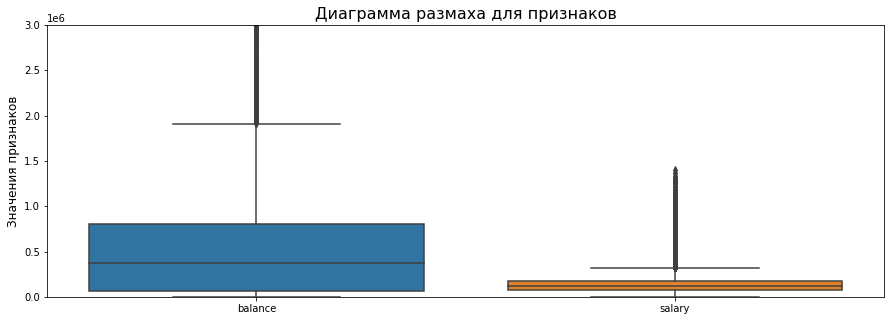

In [18]:
# диаграмма размаха
plt.figure(figsize=(15,5))    
fig = sns.boxplot(data=df[['balance', 'salary']])    
fig.set_ylim(0,3000000)    
fig.set_title('Диаграмма размаха для признаков', size=16) 
fig.set_ylabel('Значения признаков', size=12);

По обоим данным показывает большое количество выбросов. Но учитывая, что данные по зп заполнялись машиной - они могут быть далеки от реальности, по балансу - возможны редкие клиенты, имеющие на счетах большие суммы. Учитывая, что таких значений слишком много и разброс в данных получается большой, уберу часть из них из анализа (не больше 5% данных, сделаю отброс 4% у баланса и 1% у данных по зп). Создам новый отфильтрованный датасет:

In [19]:
# 96й перцентиль для данных по балансу
balance_q96 = df['balance'].quantile(.96)
df_filter = df.query('balance<@balance_q96').copy()

# 99й перцентиль для данных о доходах
salary_q99 = df_filter['salary'].quantile(.99)
df_filter = df_filter.query('salary<@salary_q99').copy()

In [20]:
# доля потерянных данных при удалении и очистке датасета
print('Доля потерянных данных: {:.2%}'.format(1-(len(df_filter)/len(df))))

Доля потерянных данных: 4.96%


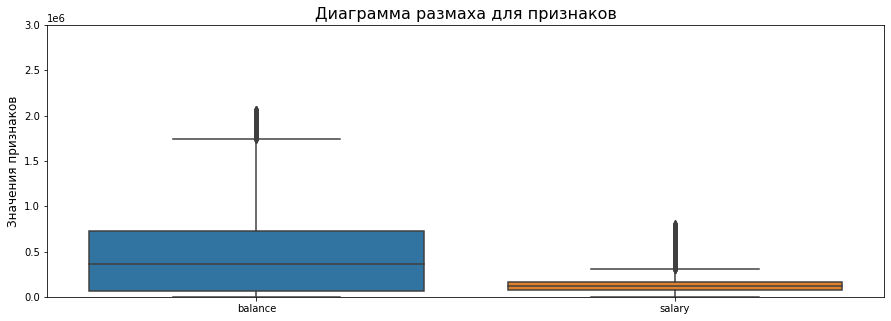

In [21]:
# диаграмма размаха
plt.figure(figsize=(15,5))    
fig = sns.boxplot(data=df_filter[['balance', 'salary']])    
fig.set_ylim(0,3000000)    
fig.set_title('Диаграмма размаха для признаков', size=16) 
fig.set_ylabel('Значения признаков', size=12);

Данные выглядят чуть лучше, остальное не меняю. Всего удалению подлежали 4,97 % данных.

### Дополнительные данные для анализа

Баланс очень разнообразен - его удобнее сгруппировать для анализа, например на 0-100000, 100000-500000, 500000-1млн, 1млн-1,5млн и от 1,5 и выше. Аналогично проведу группировки для данных о доходах:

In [22]:
df_filter['balance_group'] = pd.cut(df_filter['balance'], [-float('inf'), 100000, 250000, 500000, 
                                                           1000000, 1500000, float('inf')])

df_filter['salary_group'] = pd.cut(df_filter['salary'], [0, 50000, 100000, 250000, 400000, float('inf')])
df_filter.head()

user_id  score     city gender  age  equity     balance  products  \
0   258835    838   Ростов      Ж   32       1   377652.29         2   
1    96660    845   Ростов      Ж   31       3   214980.98         5   
2    99838    869   Ростов      Ж   30       4   467040.46         2   
3   216099    856  Рыбинск      Ж   25       4   475727.88         4   
4   120240    873  Рыбинск      Ж   37       3  1350858.40         4   

   credit_card  last_activity     salary  churn           balance_group  \
0            0              1  105665.06      1    (250000.0, 500000.0]   
1            0              1   62058.62      0    (100000.0, 250000.0]   
2            1              1  156945.23      1    (250000.0, 500000.0]   
3            0              1   19502.68      0    (250000.0, 500000.0]   
4            0              1  119804.41      0  (1000000.0, 1500000.0]   

           salary_group  
0  (100000.0, 250000.0]  
1   (50000.0, 100000.0]  
2  (100000.0, 250000.0]  
3        (0.0, 50000.0]  
4  (100000.0, 250000.0]

В ходе предобработки было проверено наличие дубликатов и пропусков, корректность данных в датасете. 

## Исследовательский анализ данных

Исследую общую информацию по представленым данным. Посмотрю как ведёт себя каждый признак, как распределены числовые значения в датасете, построю гистограммы для них, проанализирую их (для категориальных построю графики).

### Общая информация по представленным данным, распределение данных. Гистограммы

Посмотрю на средние значения и стандартные отклонения в данных (использую метод describe()):

In [23]:
df_filter.describe().T

count           mean            std     min       25%  \
user_id        9503.0  153760.271283   68979.409387  1436.0  98467.50   
score          9503.0     800.052931      75.238202   638.0    745.00   
age            9503.0      42.754183      12.191604    18.0     33.00   
equity         9503.0       2.578554       1.973651     0.0      0.00   
balance        9503.0  475819.605701  464143.509706    -1.0  58573.49   
products       9503.0       1.955698       0.664868     1.0      2.00   
credit_card    9503.0       0.853415       0.353711     0.0      1.00   
last_activity  9503.0       0.499526       0.500026     0.0      0.00   
salary         9503.0  131606.496732   91482.990936  2546.3  73232.87   
churn          9503.0       0.117331       0.321832     0.0      0.00   

                     50%        75%         max  
user_id        159667.00  213132.50   264013.00  
score             810.00     859.00      963.00  
age                40.00      51.00       86.00  
equity              3.00       4.00        9.00  
balance        362361.58  731264.41  2064255.27  
products            2.00       2.00        5.00  
credit_card         1.00       1.00        1.00  
last_activity       0.00       1.00        1.00  
salary         115765.49  167230.32   805496.91  
churn               0.00       0.00        1.00

Как видно из общих статистических данных, полученных методом describe(), можно сказать, что клиенты банка, это люди от 18 до 86 лет (в среднем в возрасте 42-43 лет), с разным уровнем дохода (зп от 2 546 до 805 496) и разным балансом на счетах (от 0 до 2 064 255). Максимальное число продуктов банка, которыми пользуются клиенты - 5 (в среднем у клиентов около 2х продуктов). В собственности до 9ти объектов движимого и недвижимого имущества (в среднем от 2х до 3х объектов). Минимальная кредитная оценка клиентов банка 638 (средняя 800).


Рассмотрю подробнее каждый показатель для всех клиентов и как они распределены (сколько активных и неактивных клиентов, сколько тех, кто имеет кредитную карту и другие характеристики с помощью графиков.

Посмотрю сколько клиентов в каждом из городов:

In [24]:
# сводная таблица по городу нахождения банка и количеству клиентов
city_and_count = df_filter.groupby(['city']).agg({'user_id':'count'}).sort_values(by='user_id', ascending=False)
city_and_count

user_id
city              
Ярославль     5522
Рыбинск       2580
Ростов        1401

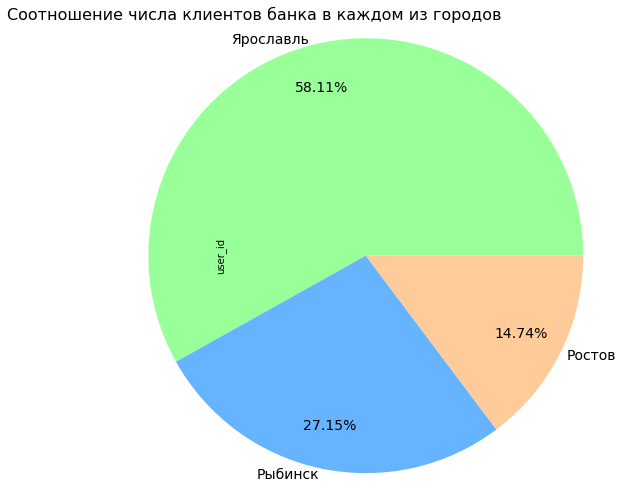

In [25]:
# постороение круговой диаграммы
# добавление цветовой гаммы
colors = ['#99ff99','#66b3ff','#ffcc99']
fig = city_and_count['user_id'].plot(kind='pie', figsize=(5,5), legend=False, autopct='%1.2f%%', 
                                     textprops={'fontsize': 14}, pctdistance=0.8, radius=2,
                                     labeldistance=1.03, colors=colors,)
fig.set_title('Соотношение числа клиентов банка в каждом из городов', loc='right', size=16, pad=100);

Большая часть клиентов находится в банке г. Ярославль (58,1 % всех клиентов), меньше всего в г. Ростов (14,7 %).

In [26]:
# количество мужчин и женщин в датасете
df_filter['gender'].value_counts()

Ж    4803
М    4700
Name: gender, dtype: int64

В целом женщин чуть больше, чем мужчин. Посмотрю как они распределены по городам:

In [27]:
# функция для создания таблицы с группировкой по 2м столбцам, 
#расчетом искомого значения и его доли среди общего количества 
def make_pivot_for_bar(df, column_1, column_2, agg_column, func):
    # сводная таблица с количеством клиентов разного пола в каждом городе
    df_pivot = (df.groupby([column_1, column_2])
                               .agg({agg_column:func})
                               .sort_values(by=agg_column, ascending=False).reset_index())

    # вспомогательныя таблица с общим количеством клиентов в городе
    type_sum=df_pivot.groupby(column_1).agg({agg_column:'sum'})
    # добавление в сводную значений из вспомогательной таблицы
    df_pivot = df_pivot.merge(type_sum, on=column_1, how='inner')
    # добавление в таблицу столбца с расчетом доли мужчин и женщин для каждого города
    df_pivot['percent'] = (df_pivot['user_id_x']/df_pivot['user_id_y']*100)
    # отсортированная таблица по городу и полу
    df_pivot = df_pivot.sort_values(by=[column_1, column_2])
    return df_pivot


# сводная таблица с количеством клиентов разного пола в каждом городе
city_and_gender = make_pivot_for_bar(df_filter, 'city', 'gender', 'user_id', 'count')
city_and_gender

city gender  user_id_x  user_id_y    percent
4     Ростов      Ж        733       1401  52.319772
5     Ростов      М        668       1401  47.680228
2    Рыбинск      Ж       1324       2580  51.317829
3    Рыбинск      М       1256       2580  48.682171
1  Ярославль      Ж       2746       5522  49.728359
0  Ярославль      М       2776       5522  50.271641

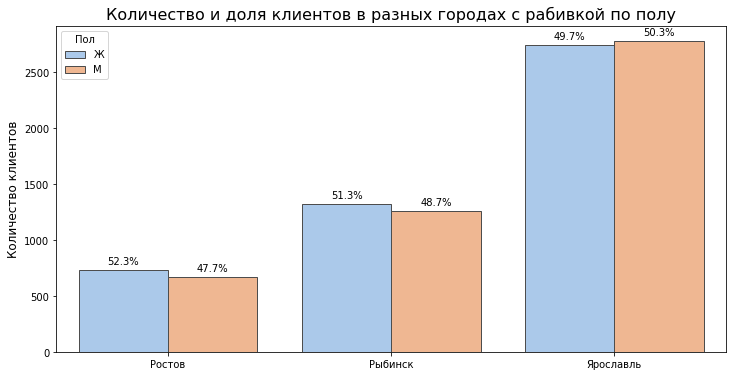

In [28]:
# функция добавления относительных значений на график
def add_percents(df, ax):
    count = 0
    percents = df['percent'].to_list()
    amount = len(percents) // 2
    for p in ax.patches:
        percentage = f'{percents[count // amount + (count % amount) * 2]:.1f}%'
        count += 1
        x = p.get_x() + p.get_width() / 2
        y = p.get_height() + 50
        ax.annotate(percentage, (x, y), ha='center')
            
# функция построения графика barplot  
def make_barplot(df, x, y, hue, title, ylabel, legend):
    # построение графика
    plt.figure(figsize=(12, 6)) 
    ax = sns.barplot(x=x, y=y, hue=hue, data=df, palette='pastel', edgecolor='.3')
    ax.axes.set_title(title, fontsize=16)
    ax.set_xlabel('')
    ax.set_ylabel(ylabel, fontsize=12)
    # добавление относительных значений на график
    add_percents(df, ax)
    plt.legend(title=legend);

# построение графика
make_barplot(city_and_gender, 'city', 'user_id_x', 'gender', 
             'Количество и доля клиентов в разных городах с рабивкой по полу', 
             'Количество клиентов', 'Пол');

Женщин в Ростове (52,3%) и Рыбинске (51,3%) немного больше чем мужчин. Иная ситуация в Ярославе, там женщин чуть меньше (49,7% против 50,3 % мужчин). Женщины в этих городах больше пользуются услугами банка или более активны? Построю сводную таблицу для таких параметров как: наличие кредитной карты, активность клиента и среднее количество используемых продуктов для клиентов разного пола в разрезе городов. На основании нее, построю графики:

In [29]:
# сводная таблица с расчетом показателей по городам и полу
cities_pivot = df_filter.pivot_table(columns=['city', 'gender'], values=['credit_card', 'last_activity', 'products'],
                                     aggfunc='mean').reset_index()
# переименование колонок
cities_pivot.columns = ['parameter', 'Ростов_Ж', 'Ростов_М', 'Рыбинск_Ж', 'Рыбинск_М', 'Ярославль_Ж', 'Ярославль_М']

cities_pivot

parameter  Ростов_Ж  Ростов_М  Рыбинск_Ж  Рыбинск_М  Ярославль_Ж  \
0    credit_card  0.796726  0.935629   0.808157   0.902070     0.778587   
1  last_activity  0.512960  0.498503   0.546073   0.533439     0.486162   
2       products  2.012278  2.017964   1.945619   1.966561     1.960306   

   Ярославль_М  
0     0.922190  
1     0.471902  
2     1.921110

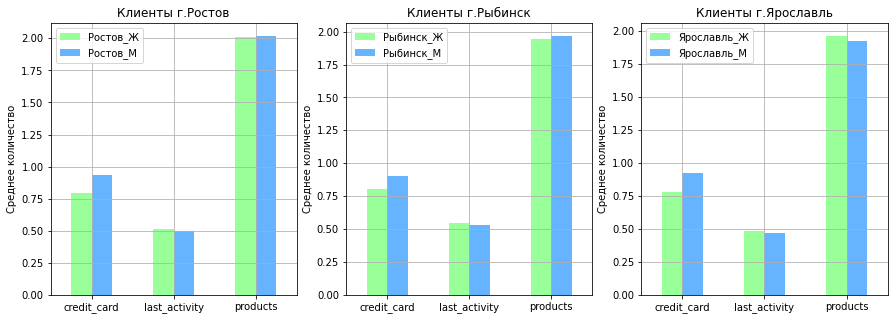

In [30]:
# функция построения графиков характеристик клиентов по городам
def make_bar_for_cities(y, ax, city):
    # график значений характеристик клиентов
    cities_pivot.plot(kind='bar', x='parameter', y=y, ax=ax, title=f'Клиенты г.{city}', xlabel='', 
                      ylabel='Среднее количество', color=['#99ff99', '#66b3ff'], grid=True)
    plt.xticks(rotation=0)

# построение графиков    
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(131)
make_bar_for_cities(['Ростов_Ж', 'Ростов_М'], ax1, 'Ростов')
ax2 = fig.add_subplot(132)
make_bar_for_cities(['Рыбинск_Ж', 'Рыбинск_М'], ax2, 'Рыбинск')
ax3 = fig.add_subplot(133) 
make_bar_for_cities(['Ярославль_Ж', 'Ярославль_М'], ax3, 'Ярославль')

Очень заметной разницы в поведении клиентов по использованию кредитных карт и активности не заметно между городами: во всех городах женщины чуть более активны, но меньше используют кредитные карты. Среднее количество используемых продуктов по городам немного различается: больше всего продуктов банка у мужчин в Ростове и Рыбинске (причем в Ростове вцелом среднее количество используемых продуктов немного выше по сравнению с другими городами). В Ярославле наоборот, у женщин чуть больше продуктов.

Посмотрю остальные признаки по клиентам. Для удобства отдельно рассмотрю числовые и булевые значения:

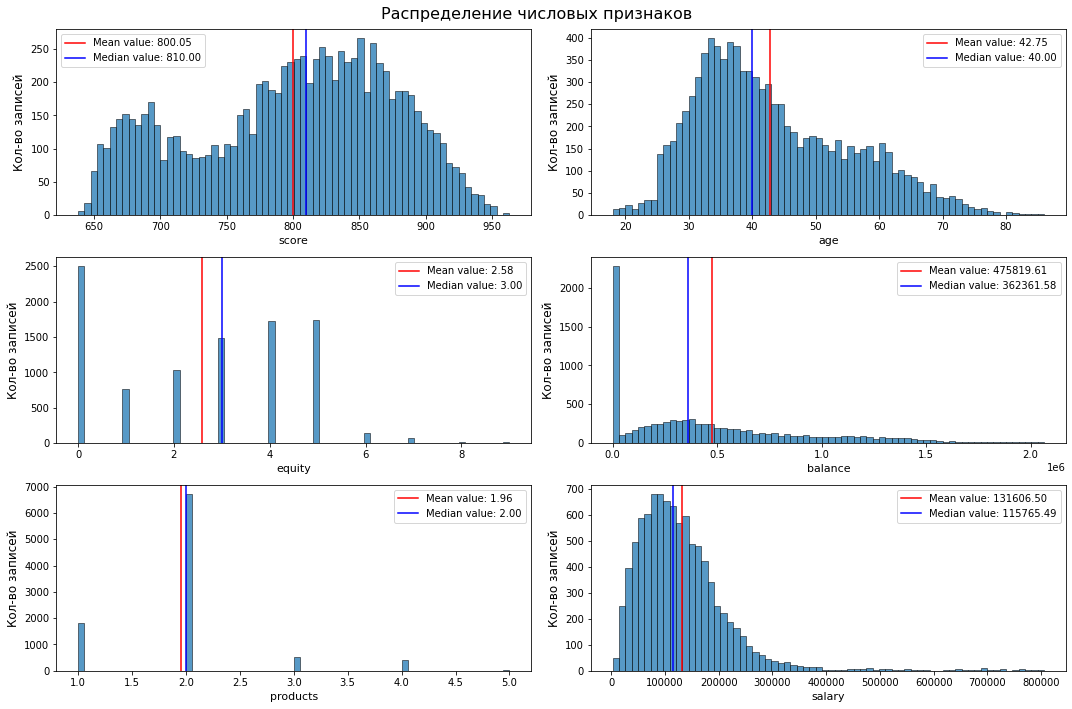

In [31]:
# числовые признаки
numeric_df = df_filter[['score', 'age', 'equity', 'balance', 
                 'products', 'salary']]
# булевые признаки
bool_df = df_filter[['credit_card', 'last_activity', 'churn']]


# распределения для числовых данных
fig, axes = plt.subplots(3, 2, figsize=(15, 10))
axes_list = [item for sublist in axes for item in sublist]
fig.suptitle('Распределение числовых признаков', fontsize=16)

for data in numeric_df.columns:
    ax = axes_list.pop(0)
    # построение гистограммы
    sns.histplot(df_filter[data], ax=ax, bins=68)
    ax.set_xlabel(data, fontsize=11)
    ax.set_ylabel('Кол-во записей', fontsize=12)
    # вывод линии среднего и медианного значения н график
    mean = df_filter[data].describe()['mean']
    median = df_filter[data].describe()['50%']
    ax.axvline(mean, color='r', label=f'Mean value: {mean:.2f}')
    ax.axvline(median, color='b', label=f'Median value: {median:.2f}')
    ax.legend()
fig.tight_layout();     

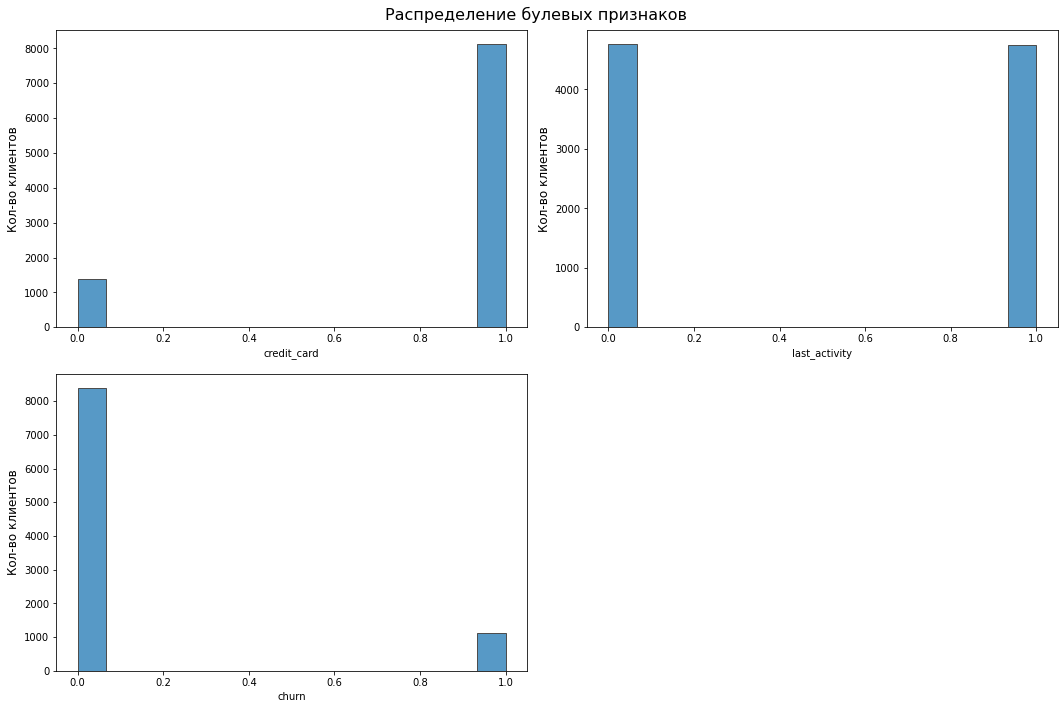

In [32]:
# распределения для булевых данных
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes_list = [item for sublist in axes for item in sublist]
fig.suptitle('Распределение булевых признаков', fontsize=16)
for data in bool_df.columns:
    ax = axes_list.pop(0)
    sns.histplot(x=data, data=df_filter, ax=ax, palette="pastel", edgecolor=".3")
    ax.set_ylabel('Кол-во клиентов', fontsize=12)
   
fig.tight_layout()
# удаление лишней ячейки    
fig.delaxes(axes[1][1])

#### Вывод

Кредитная оценка:

- большая часть клиентов банка имеет хорошую кредитную оценку (в среднем 800 баллов). Распределение score бимодальное, и условно делит клиентов на две группы: обеспеченных и менее обеспеченых (со средней оценкой в районе 840 баллов и около 680 соответственно). 

Возраст клиентов:

- меньше всего клиентов до 25 лет (скорее всего тут связано с тем, что студенты мало пользуются услугами банка). С 26 лет их количество увеличивается почти втрое, и это основная масса клиентов до 47 лет- тут скорее всего уже работающие люди, готовые брать кредиты, инвестировать свои средства. Большая часть этих клиентов возраста 30-45 лет. После 48 лет и до 62 их количество примерно одинаковое. Тех кому за 70 (пенсионеров) снова становится меньше (стабильных заработков нет, люди уже практически не пользуются услугами банка). Таким образом, можно выделить в группы клиентов от 18-25, с 26-47, с 48-62, с 63-69 и после 70 лет.

Количество объектов в собственности:

- много клиентов, у которых не числится никакая собственность (вероятнее всего и кредитов у них нет), и тех, у кого их от 3х до 5ти. Шесть и более объектов имеет очень малое количество людей. 

Баланс на счете:

- В основном у клиентов банка на счетах либо до 100 000, либо от 100 000 до 500 000. Есть те, у кого от 500 000 до 1,5 млн и совсем мало тех, у кого больше. В среднем баланс 362 000 (учитываю медианное значение, так как очень большой разброс в данных).

Количество продуктов, которыми пользуется клиент:

- большая часть клиентов имеет 2 банковских продукта, совсем мало тех, у кого 3-4 и единицы, у кого их 5.

Заработная плата клиента:

- в среднем доход 115 000 (считаю медианное значение, так как есть те, у кого она маленькая, а есть у кого очень высокая). Доходы свыше 400 000 встречаются реже, в основном встречаются заработные платы от 40 000 до 200 000.

Наличие кредитной карты, активность и отточность:

- в основном все клиенты имеют кредитную карту; активных и неактивных клиентов примерно одинаково; тех, кто попал в отток меньше, чем тех, кто не попал, что уже хорошо.

### Анализ средних значений в двух группах

Посмотрю на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался:

In [33]:
# группировка и расчет среднего
df_filter.groupby('churn').mean()

user_id       score        age    equity        balance  \
churn                                                                  
0      154025.444921  790.879471  43.248689  2.396757  422876.163155   
1      151765.404484  869.063677  39.034081  3.946188  874106.238960   

       products  credit_card  last_activity         salary  
churn                                                       
0      1.884359     0.886981       0.458512  131196.624014  
1      2.492377     0.600897       0.808072  134689.915883

**Вывод**

Средний возраст тех, кто попал в отток чуть меньше (39 лет против 43, кто остался); у тех кто в оттоке, больше объектов в собственности, возможно выше баланс (по неотточным есть не все данные по балансу), доходы и больше продуктов банка, при этом они и более активны, их кредитная оценка выше. Получается, что в отток попадают очень значимые клиенты. Не устраивает обслуживание или предложения банка? Проанализирую все признаки клиентов по отточности.

### Распределение признаков по группам (оттока). Гистограммы

Чтобы увидеть как ведут себя признаки для тех, кто ушёл (отток) и тех, кто остался (не попали в отток) построю столбчатые гистограммы распределения признаков. Так как признаков много, разделю их условно на числовые, булевые (те, что принимают значения 0 и 1) и категориальные и для каждых построю графики.

Посмотрю, есть ли разница оттока в разных городах:

In [34]:
# сводная таблица по городу нахождения банка и количеству клиентов
churn_for_city = make_pivot_for_bar(df_filter, 'city', 'churn', 'user_id', 'count')
churn_for_city

city  churn  user_id_x  user_id_y    percent
4     Ростов      0       1234       1401  88.079943
5     Ростов      1        167       1401  11.920057
2    Рыбинск      0       2334       2580  90.465116
3    Рыбинск      1        246       2580   9.534884
0  Ярославль      0       4820       5522  87.287215
1  Ярославль      1        702       5522  12.712785

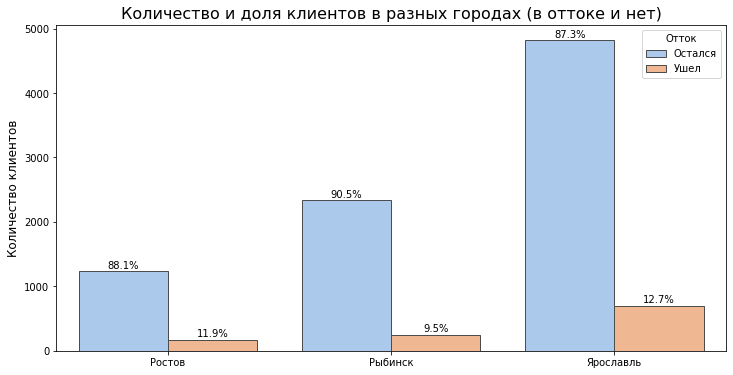

In [35]:
# функция для замены названия в легенде
def replace_chain(is_churn):
    if is_churn == 1:
        return 'Ушел'
    elif is_churn == 0:
        return 'Остался'
    
# замена значений в столбце    
churn_for_city['churn']=churn_for_city['churn'].map(replace_chain)

# построение графика
make_barplot(churn_for_city, 'city', 'user_id_x', 'churn', 
             'Количество и доля клиентов в разных городах (в оттоке и нет)', 
             'Количество клиентов', 'Отток');

Больше всего уходят клиенты в Ярославле (12,7%), меньше в Рыбинске (9,5%). 

Посмотрю есть ли разница между мужчинами и женщинами в оттоке:

In [36]:
# сводная таблица по количеству клиентов в оттоке и нет с разбивкой по полу
churn_for_gender = make_pivot_for_bar(df_filter, 'gender', 'churn', 'user_id', 'count')
# замена значений в столбце    
churn_for_gender['churn']=churn_for_gender['churn'].map(replace_chain)
churn_for_gender

gender    churn  user_id_x  user_id_y    percent
0      Ж  Остался       4324       4803  90.027066
1      Ж     Ушел        479       4803   9.972934
2      М  Остался       4064       4700  86.468085
3      М     Ушел        636       4700  13.531915

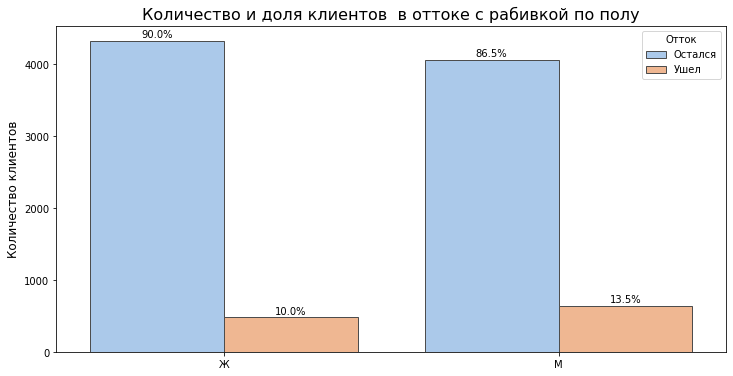

In [37]:
# построение графика
make_barplot(churn_for_gender, 'gender', 'user_id_x', 'churn', 
             'Количество и доля клиентов  в оттоке с рабивкой по полу', 
             'Количество клиентов', 'Отток');

Мужчин уходит чуть больше - 13,5% против 10% женщин. И это учитывая, что женщины более активны... Возможно боятся перемен, а возможно им не предлагают конкуренты лучших условий (это может быть связано с тем, что доход женщины не всегда стабилен, например, на время декретного отпуска. И банки чаще им отказывают в том же рефинансировании или кредите).

Посмотрю распределения числовых и булевых признаков. Построю гистограммы. Так как количество наблюдений для групп оттока в данных разное (гистограммы несопоставимы), применю при построении параметр stat='density' и для нормализации каждой гистограммы отдельно - парметр common_norm=False : 

In [38]:
df_filter['churn_']=df_filter['churn'].map(replace_chain)
# распределения для числовых данных
fig, axes = plt.subplots(3, 2, figsize=(15, 10))
axes_list = [item for sublist in axes for item in sublist]
fig.suptitle('Распределение числовых признаков', fontsize=16)

for data in numeric_df.columns:
    ax = axes_list.pop(0)
    fig = sns.histplot(data=df_filter, x=df_filter[data], ax=ax, hue='churn_', hue_order=['Остался', 'Ушел'],
                 stat='density', common_norm=False,)
    fig.set_ylabel('Относительная частота', fontsize=12)
    legend = fig.get_legend()
    legend.set_title('Группы оттока') 

Большинство клиентов, попавших в отток имели хорошую кредитную оценку (выше 820), более 4х объектов в собственностии, их баланс на счету выше 800 000, у них более 2х продуктов банка (те у кого один продукт практически не попадают в отток),чуть выше доход. Резкий скачок оттока от дохода 100 000 и выше. Получается, что уходят одни из лучих клиентов. Возможно им дают лучше условия в другом банке.

Немного детальней рассмотрю отточность у клиентов в зависимости от возраста, баланса и дохода. Добавлю объединение клиентов по группам, основанное на предыдущем анализе (п 3.1.1) и посмотрю средний отток в каждой группе, построю график:

In [39]:
# функция для построения графика среднего оттока в группах
def make_plot_for_group (df, name):
    plt.figure(figsize=(10,6))
    df['mean'].plot(grid=True, title=f'Средний отток по группам в зависимости от {name}')
    plt.ylabel('Доля оттока');

# функция для создания сводной таблицы по группам, расчета в них среднего оттока,
# построения графика отточности в группах
def churn_mean_for_group(df, column, name):
    group = df.groupby(column)['churn'].agg(['count', 'mean'])
    # проверка разделения (общее количество должно совпадать с начальным датасетом)
    print('Всего клиентов в группах:', group['count'].sum(), f'из  {len(df)} в анализируемом датасете' )
    #display(group)
    # построение графика среднего оттока в группе
    make_plot_for_group (group, name)

    
# выделение в группы клиентов 
df_filter['age_group'] = pd.cut(df_filter['age'], [0, 25, 47, 62, 69, 87])

# построение графика среднего оттока в группах по возрасту клиентов
churn_mean_for_group(df_filter, 'age_group', 'возраста')

Всего клиентов в группах: 9503 из  9503 в анализируемом датасете


В основном уходят клиенты  до 62 лет (25-47 лет уходят чаще). После 62 лет отток снижается (пенсионеры более стабильны в своем выборе и не стремятся уходить).

Всего клиентов в группах: 9503 из  9503 в анализируемом датасете


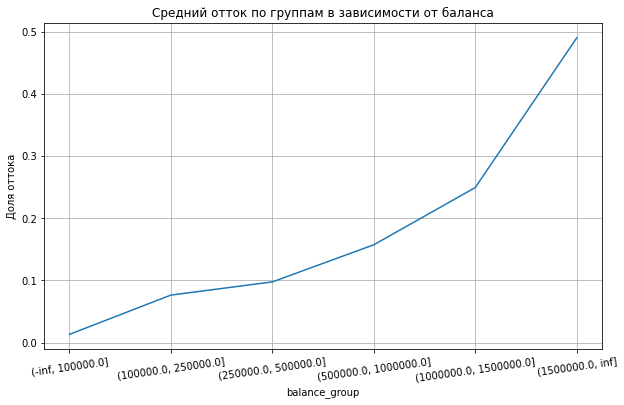

In [41]:
# построение графика среднего оттока в группах по балансу клиентов
churn_mean_for_group(df_filter, 'balance_group', 'баланса')
plt.xticks(rotation=8);

Почти 50% клиентов имеющих баланс выше 1,5 млн уходят. Не интересные предложения по инвестициям и вкладам или их отсутствие?

Всего клиентов в группах: 9503 из  9503 в анализируемом датасете


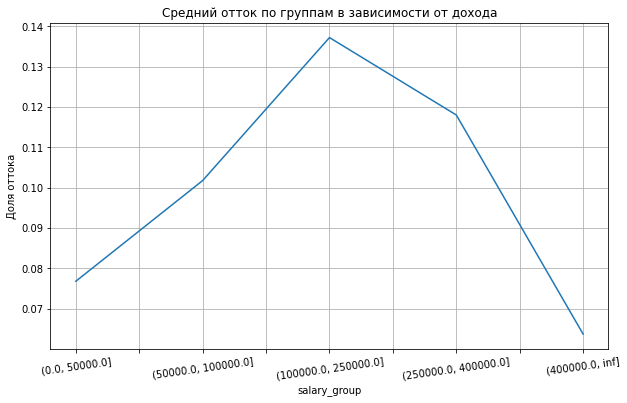

In [42]:
# построение графика среднего оттока в группах по доходу клиентов
churn_mean_for_group(df_filter, 'salary_group', 'дохода')
plt.xticks(rotation=8);

Самый высокий отток у клиентов с доходом от 100 000 до 250000, чуть меньше у кого до 400 000 и после доходов в 400 000 отток практически стремится к нулю.

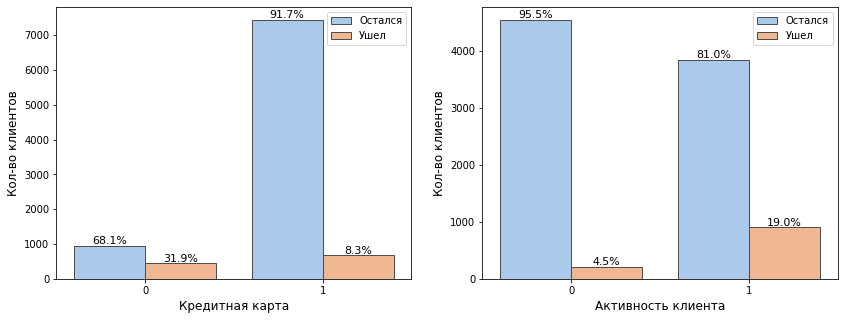

In [43]:
# функция расчета процентов для графика
def percent_above_bar(ax):
    all_heights = [[p.get_height() for p in bars] for bars in ax.containers]
    for bars in ax.containers:
        for i, p in enumerate(bars):
            total = sum(xgroup[i] for xgroup in all_heights)
            percentage = f'{(100 * p.get_height() / total) :.1f}%'
            ax.annotate(percentage, (p.get_x() + p.get_width() / 2, p.get_height()), size=11, ha='center', va='bottom')

# функция построения графика типа countplot
def make_countplot(df, x, xlabel):
    fig = sns.countplot(x=x, hue='churn_', data=df, palette="pastel", edgecolor=".3", hue_order=['Остался', 'Ушел'])
    fig.set_ylabel('Кол-во клиентов', fontsize=12)
    fig.set_xlabel(xlabel, fontsize=12)
    fig.legend();
    percent_above_bar(fig)
    
# построение графиков оттока клиентов в зависимости от наличия кредитной карты
# и их активности
plt.figure(figsize=(14,5))
plt.subplot(1, 2, 1)
make_countplot(df_filter, 'credit_card', 'Кредитная карта')    
plt.subplot(1, 2, 2);
make_countplot(df_filter, 'last_activity', 'Активность клиента')

Отток среди тех, кто не имеет кредитную карту выше (31,9% у кого нет кредитной карты уходят). А так же среди уходящих много активных клиентов. Получается, что те, кто чаще пользуется услугами банка (вносит средства на счет, берет кредиты, пользуется другими продуктами - уходят чаще). Снова неудовлетворенность от предлагаемых услуг?

#### Вывод

В отток попадают:

- в возрасте после 22 лет. Большая часть 30-45 лет, 50-60 лет. После 65 лет клиенты остаются.
- чаще это клиенты банка в г. Ярославь
- у мужчин отток чуть выше (13,5% против 10% женщин)
- имеющие более 4х объектов в собственности
- их кредитная оценка выше 820
- их баланс на счету выше 1 млн (отток клиентов почти 50% имеющих баланс выше 1,5 млн)
- чаще клиенты с доходами от 100 000 - 250 000 
- у них более 2х продуктов банка
- чаще те у кого нет кредитной карты
- более активные клиенты

### Коррелирование данных. Зависимость оттока  от других показателей. Матрица корреляций

Посмотрю зависимость оттока от остальных показателей, какие влияют больше, какие меньше. Для этого построю матрицу корреляций и отображу её с помощью тепловой карты. 
В данных есть показатели с категориальным неупорядоченным (город, пол). Для того, чтобы применять среднее и смотреть их корреляции применю one-hot кодирование при помощи метода pandas.get_dummies:

In [44]:
# таблица с закодированными категориальными переменными
df_with_categ = pd.get_dummies(df_filter.drop(['balance_group', 'salary_group', 'age_group', 'churn_'], axis=1),
                               columns=['city', 'gender'])

# вычисление матрицы корреляций
cm = df_with_categ.drop('user_id', axis=1).corr() 
cm

score       age    equity   balance  products  credit_card  \
score           1.000000  0.036562  0.717351  0.640628  0.536783    -0.262240   
age             0.036562  1.000000  0.025663  0.161820  0.000383    -0.022878   
equity          0.717351  0.025663  1.000000  0.668483  0.505392    -0.231870   
balance         0.640628  0.161820  0.668483  1.000000  0.440626    -0.274808   
products        0.536783  0.000383  0.505392  0.440626  1.000000    -0.135467   
credit_card    -0.262240 -0.022878 -0.231870 -0.274808 -0.135467     1.000000   
last_activity  -0.079973 -0.004439 -0.020304 -0.023806  0.026370    -0.043533   
salary         -0.184546 -0.045726 -0.251287 -0.082710 -0.242428     0.049586   
churn           0.334433 -0.111256  0.252657  0.312878  0.294313    -0.260301   
city_Ростов     0.016905  0.049507  0.041276  0.014444  0.037085     0.011217   
city_Рыбинск    0.025495  0.035193 -0.001279 -0.001535  0.000106     0.000796   
city_Ярославль -0.035128 -0.067297 -0.028506 -0.008995 -0.026744    -0.008778   
gender_Ж        0.081828  0.229682  0.034255  0.038046  0.012911    -0.182658   
gender_М       -0.081828 -0.229682 -0.034255 -0.038046 -0.012911     0.182658   

                last_activity    salary     churn  city_Ростов  city_Рыбинск  \
score               -0.079973 -0.184546  0.334433     0.016905      0.025495   
age                 -0.004439 -0.045726 -0.111256     0.049507      0.035193   
equity              -0.020304 -0.251287  0.252657     0.041276     -0.001279   
balance             -0.023806 -0.082710  0.312878     0.014444     -0.001535   
products             0.026370 -0.242428  0.294313     0.037085      0.000106   
credit_card         -0.043533  0.049586 -0.260301     0.011217      0.000796   
last_activity        1.000000 -0.002692  0.224987     0.005440      0.049321   
salary              -0.002692  1.000000  0.012289    -0.105700     -0.013797   
churn                0.224987  0.012289  1.000000     0.002415     -0.041700   
city_Ростов          0.005440 -0.105700  0.002415     1.000000     -0.253855   
city_Рыбинск         0.049321 -0.013797 -0.041700    -0.253855      1.000000   
city_Ярославль      -0.048366  0.088389  0.035852    -0.489751     -0.718977   
gender_Ж             0.014638 -0.096400 -0.055292     0.014787      0.009474   
gender_М            -0.014638  0.096400  0.055292    -0.014787     -0.009474   

                city_Ярославль  gender_Ж  gender_М  
score                -0.035128  0.081828 -0.081828  
age                  -0.067297  0.229682 -0.229682  
equity               -0.028506  0.034255 -0.034255  
balance              -0.008995  0.038046 -0.038046  
products             -0.026744  0.012911 -0.012911  
credit_card          -0.008778 -0.182658  0.182658  
last_activity        -0.048366  0.014638 -0.014638  
salary                0.088389 -0.096400  0.096400  
churn                 0.035852 -0.055292  0.055292  
city_Ростов          -0.489751  0.014787 -0.014787  
city_Рыбинск         -0.718977  0.009474 -0.009474  
city_Ярославль        1.000000 -0.019165  0.019165  
gender_Ж             -0.019165  1.000000 -1.000000  
gender_М              0.019165 -1.000000  1.000000

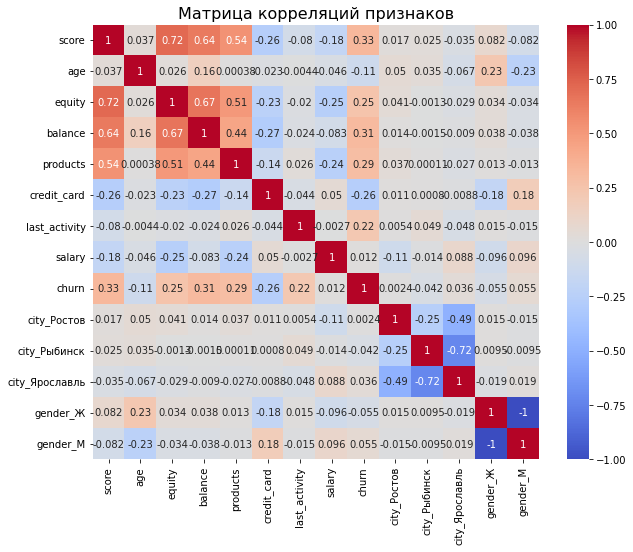

In [45]:
# построение и отрисовка матрицы корреляций
fig, ax = plt.subplots(figsize=(10, 8))
# тепловая карта с подписями для матрицы корреляций
sns.heatmap(data=cm, square = False, annot = True, fmt = '.2g', vmin=-1, vmax=1, center= 0, cmap='coolwarm')
plt.title('Матрица корреляций признаков', fontsize = 16)
plt.show()

Прослеживается хорошая взаимосвязь кредитной оценки с числом объектов в собственности и балансом, чуть менее от количества используемых услуг в банке. Судя по всему это основные критерии банка для получения кредитной оценки.

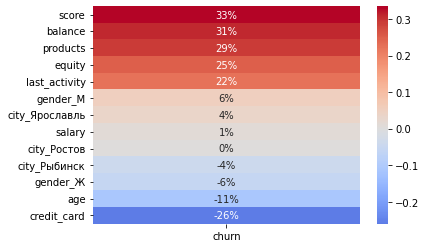

In [46]:
# корреляция отточности с другими признаками
sns.heatmap(cm.loc[:,['churn']].drop('churn').sort_values(by='churn', ascending=False),
            annot = True, fmt = '.0%', center= 0, cmap='coolwarm');

**Вывод**

На отток влияние слабое везде, но самые значимые все равно проявляются, это: кредитная оценка (один из самых высоких коэффициентов корреляции-33%), баланс, кол-во используемых продуктов и объектов в собственности, активность клиентов. Отрицательное влияние у возраста и наличию кредитной карты, что еще раз подтверждает предыдущие выводы (более молодой сегмент и отсутствие кредитки у более отточных). Практически нулевое влияние пола, города и доходов.

### Объединение в группы. Отток в зависимоти от местонахождения, пола и возраста клиента

Чтобы определить каким клиентам что лучше предлагать, посмотрю насколько эти клиенты отличаются друг от друга по отточности в зависимости от города их нахождения, пола и возраста:

In [47]:
# вспомогательный датасет
df_dop = df_filter.copy()
df_dop['age_group'] = df_dop['age_group'].astype('str')
# сводная отточности таблица по городам, полу и возрастным группам
users_cities = df_dop.groupby(['city', 'gender', 'age_group']).agg({'user_id':'count', 'churn':'mean'}).reset_index()
users_cities['churn']=users_cities['churn'].round(2)
users_cities.head()

city gender age_group  user_id  churn
0  Ростов      Ж   (0, 25]       14   0.14
1  Ростов      Ж  (25, 47]      382   0.14
2  Ростов      Ж  (47, 62]      211   0.05
3  Ростов      Ж  (62, 69]       94   0.04
4  Ростов      Ж  (69, 87]       32   0.00

In [48]:
# диаграмма отточности клиентов в зависимости от города и пола
fig = px.scatter(users_cities, x='gender', y='age_group', size='churn', color="gender", 
                 facet_col="city", size_max=55, title='Доля оттока клиентов в зависимости от города и пола',
                 text='churn')
fig.show()

**Вывод**

По диаграмме хорошо видно, что в Ростове и Рыбинске клиенты после 69 лет не уходят (в Рыбинске почти нет оттока уже и после 62 лет). Что нельзя сказать о клиентах в г. Ярославль: среди людей пенсионного возраста достаточно большой отток мужчин. Не хочется думать,что причины в высокой смертности среди мужчин этого возраста, предположу, что им не очень интересны предложения банка по услугам (возможно нет интересных программ для пенсионеров).

Большой отток в Рыбинске у мужчин до 25 лет и такой же в Ростове у мужчин от 47 до 62 лет.

В Ростове и Ярославе женщины до 47 лет практически одинаково отточны, в Рыбинске этот возраст менее отточен.

### Вывод

**Общие характеристики клиентов**

Кредитная оценка:

- большая часть клиентов банка имеет хорошую кредитную оценку (в среднем 800 баллов)

Возраст клиентов:

-  меньше всего клиентов до 25 лет (скорее всего тут связано с тем, что студенты мало пользуются услугами банка). С 26 лет их количество увеличивается почти втрое, и это основная масса клиентов до 47 лет- тут скорее всего уже работающие люди, готовые брать кредиты, инвестировать свои средства. Большая часть этих клиентов возраста 30-45 лет. После 48 лет и до 62 их количество примерно одинаковое. Тех кому за 70 (пенсионеров) снова становится меньше (стабильных заработков нет, люди уже практически не пользуются услугами банка). 

Количество объектов в собственности:

- много клиентов, у которых не числится никакая собственность (вероятнее всего и кредитов у них нет), и тех, у кого их 3-5
- 6 и более объектов имеет очень малое количество людей.

Баланс на счете:

- В основном у клиентов банка на счетах либо до 100 000, либо от 100 000 до 500 000. Есть те, у кого от 500 000 до 1,5 млн и совсем мало тех, у кого больше. В среднем баланс 362 000.

Количество продуктов, которыми пользуется клиент:

- большая часть клиентов имеет 2 банковских продукта, совсем мало тех, у кого 3-4 и единицы, у кого их 5.

Доходы клиентов:

- в среднем зп 115 000. Доходы свыше 400 000 встречаются реже, в основном это заработные платы от 40 000 до 200 000.

Наличие кредитной карты, активность и отточность:

- основная часть клиентов имеют кредитную карту; активных и неактивных клиентов примерно одинаково; в отток попадает менее 20%  клиентов. 

**Характерные черты отточных клиентов**

- большая часть отточных клиентов 30-45 лет (как раз тот период, когда большая часть клиентов ориентирована на кредиты (ипотека, авто, свадьбы...). После 65 лет клиенты больше остаются.
- чаще это клиенты банка в г. Ярославь
- у мужчин отток чуть выше (13,5% против 10% женщин)
- возраст и пол отточных клиентов отличается в зависимости от города: в Ростове и Рыбинске клиенты после 69 лет не уходят. В Ярославле одинаково большой отток среди мужчин и женщин до 62 лет и только мужчин после 69. В Рыбинске уходят в основном мужчины до 47 лет. В Ростове женщины до 47 и мужчины от 25-62 лет (причем от 47-62 уходят чаще).
- имеющие более 4х объектов в собственности
- их кредитная оценка выше 820
- их баланс на счету выше 1 млн (отток клиентов почти 50% имеющих баланс выше 1,5 млн)
- клиенты с доходами от 100 000 - 250 000 уходят чаще
- у них более 2х продуктов банка
- те у кого нет кредитной карты уходят чаще
- более активные клиенты

## Модель прогнозирования оттока клиентов 

Чтобы понять, что же можно предложить клиентам из этих категорий, попробую провести классификацию оттока с помощью моделей машинного обучения и посмотреть, какие важные признаки даст лучшая модель. Сойдутся ли эти признаки с тем, что выяснилось при анализе выше (что большее влияние оказывает креитная оценка, баланс, кол-во используемых продуктов и объектов в собственности, активность клиентов).

### Подготовка данных

Построю модель бинарной классификации клиентов, где целевой признак — факт оттока клиента. Возьму несколько подходящих моделей: LogisticRegression DecisionTreeClassifier, RandomForestClassifier, GradientBoostingClassifier. Для построения моделей данные необходимо разбить на обучающую и валидационную выборку функцией train_test_split() и стандартизировать.

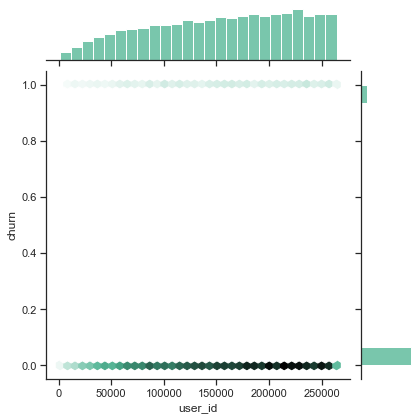

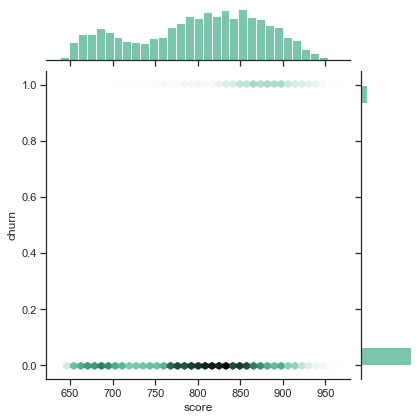

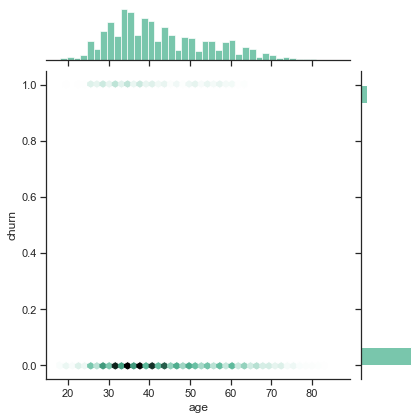

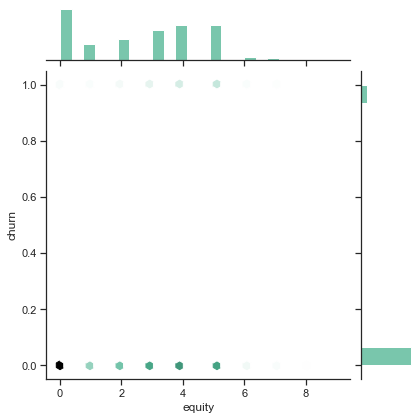

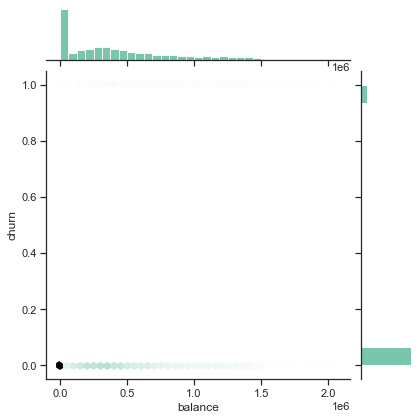

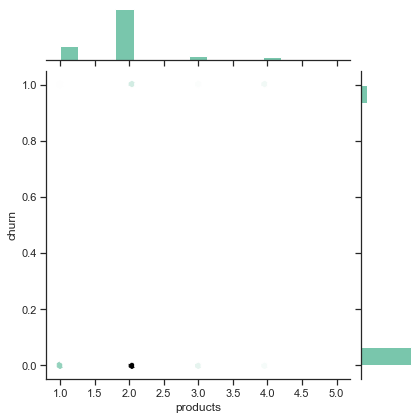

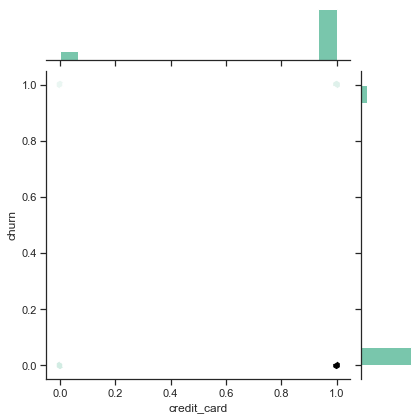

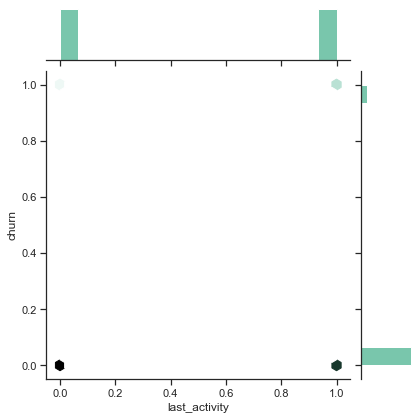

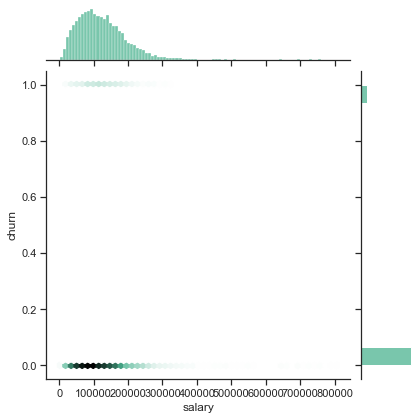

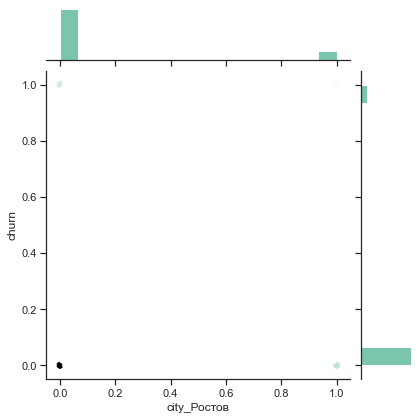

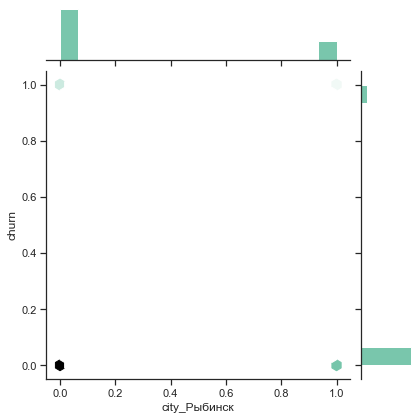

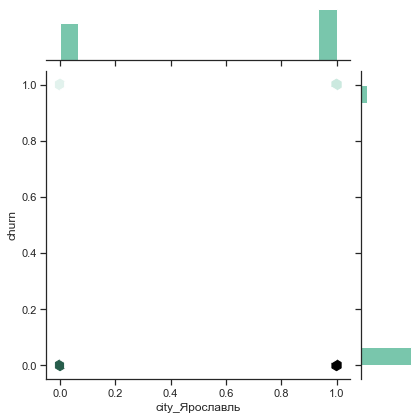

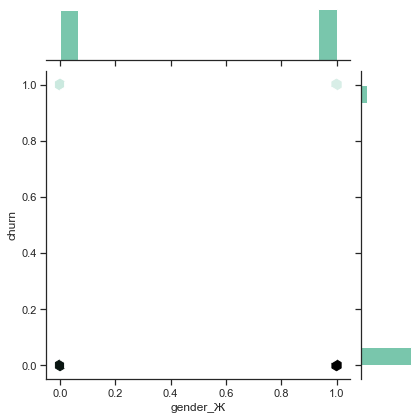

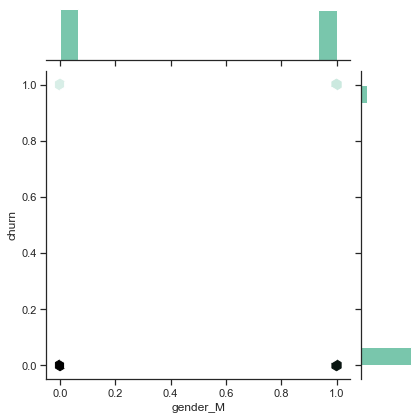

In [49]:
#построим попарные диаграммы рассеяния признак-целевая переменная для каждого признака
#for col in df_with_categ.drop('churn', axis = 1).columns:
#    sns.scatterplot(x=df_with_categ[col], y=df_with_categ['churn'])
#   plt.show();

for col in df_with_categ.drop('churn', axis = 1).columns:
    sns.set_theme(style="ticks")
    x = df_with_categ[col]#rs.gamma(2, size=1000)
    y = df_with_categ['churn']#-.5 * x + rs.normal(size=1000)
    sns.jointplot(x=x, y=y, kind="hex", color="#4CB391")

Каких-то ярких выбросов и перекосов по диаграммам не наблюдается. Исключение на диаграмме баланса, данные где были пропущенные значения и замененные на -1. Значит, на этих данных можно строить модель.

In [50]:
# деление данных на признаки (матрица X) и целевую переменную (y)
X = df_with_categ.drop('churn', axis=1)
y = df_with_categ['churn'] 
# разделение модели на обучающую и валидационную выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# создание объекта класса StandardScaler и применение его к обучающей выборке
scaler = StandardScaler()

Проверю чтобы в тесте и трейне была одинаковая доля ушедших и оставшихся:

In [51]:
print('Доли классов:')
print('для y_train \n', y_train.value_counts(normalize=True))
print('для y_test \n', y_test.value_counts(normalize=True))

Доли классов:
для y_train 
 0    0.882136
1    0.117864
Name: churn, dtype: float64
для y_test 
 0    0.884797
1    0.115203
Name: churn, dtype: float64


Сделаю разделение выборки с доп. параметром stratify и посмотрю уравняются ли размеры классов в наборах данных, разделенных для обучения и тестирования. 

In [52]:
# разделение модели на обучающую и валидационную выборки с использованием стратификации
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

print('Доли классов после стратификации')
print('для y_train \n', y_train.value_counts(normalize=True))
print('для y_test \n', y_test.value_counts(normalize=True))

Доли классов после стратификации
для y_train 
 0    0.882662
1    0.117338
Name: churn, dtype: float64
для y_test 
 0    0.882693
1    0.117307
Name: churn, dtype: float64


Доли уравнялись, можно создавать модели. 

### Обучение модели и расчет метрик

Так как датасет несбалансирован применю метод противодействия дисбалансу class_weight = balanced. Для логистической регрессии установлю penalty='l1' для регуляризации коррелирующих данных.

Выведу основные метрики для моделей, чтобы определить лучшую и на ее основе классифицировать признаки оттока:

In [53]:
models = [LogisticRegression(penalty='l1', solver='liblinear', random_state=0, class_weight='balanced'),    
    DecisionTreeClassifier(random_state=0),
    RandomForestClassifier(random_state=0, class_weight='balanced'),
    GradientBoostingClassifier(random_state=0),]

# функция, которая принимает на вход модель и данные и выводит метрики
def make_prediction(m, X_train, y_train, X_test, y_test):
    # алгоритм для модели
    model = m
    # обучение модели
    model.fit(X_train, y_train)
    # прогнозы для уже обученной модели
    y_pred = model.predict(X_test)
    # использование уже обученной модели, чтобы сделать прогнозы
    probabilities = model.predict_proba(X_test)[:,1]

    # вывод основных метрик
    print('Площадь под кривой ошибок :AUC ROC={:.3f}   F1-мера:F1:={:.3f} Точность:precision={:.3f} Полнота:recall:={:.3f} '.format(
            roc_auc_score(y_test, probabilities),
            f1_score (y_test, y_pred),
            precision_score(y_test, y_pred),
            recall_score(y_test,y_pred)))
    
# цикл, который выводит метрики по списку моделей
for i in models:
    print('\nМодель прогнозирования:', i)
    make_prediction(i, X_train, y_train, X_test, y_test)                             


Модель прогнозирования: LogisticRegression(class_weight='balanced', penalty='l1', random_state=0,
                   solver='liblinear')
Площадь под кривой ошибок :AUC ROC=0.912   F1-мера:F1:=0.576 Точность:precision=0.427 Полнота:recall:=0.883 

Модель прогнозирования: DecisionTreeClassifier(random_state=0)
Площадь под кривой ошибок :AUC ROC=0.899   F1-мера:F1:=0.795 Точность:precision=0.759 Полнота:recall:=0.834 

Модель прогнозирования: RandomForestClassifier(class_weight='balanced', random_state=0)
Площадь под кривой ошибок :AUC ROC=0.986   F1-мера:F1:=0.824 Точность:precision=0.908 Полнота:recall:=0.753 

Модель прогнозирования: GradientBoostingClassifier(random_state=0)
Площадь под кривой ошибок :AUC ROC=0.986   F1-мера:F1:=0.842 Точность:precision=0.903 Полнота:recall:=0.789 


**Вывод**

Метрика AUC ROC вполне достойная почти у всех моделей —  0.9 и выше. Можно сказать, что модели  неплохо умеет прогнозировать стабильность инфраструктуры. 

Важной метрикой является recall, чем она ближе к 1, тем точнее предсказываем, что клиент не уйдет (у модели DecisionTreeClassifier она 0,834, можно построить дерево принятия решений для определения оттока)

По остальным метрикам лучшие модели: RandomForestClassifier и GradientBoostingClassifier

### Анализ важности признаков у модели

Чтобы оценить адекватность модели, посмотрю, какие признаки модель посчитала важными при расчёте прогноза. Заново обучу лучшую модель (возьму RandomForestClassifier) и сделаю прогноз. Создам датафрейм с важностью признаков и проанализирую, какие признаки оказались наиболее важны для этой модели. Так же посмотрю метрику roc_auc, которая оценивает качество модели классификации:

In [54]:
# обучение лучшей модели
final_model1 = RandomForestClassifier(random_state=0, class_weight='balanced')
final_model1.fit(X_train, y_train)
y_pred = final_model1.predict(X_test)
# датафрейм с именами признаков и их важностью 
features1 = pd.DataFrame({'feature':X_train.columns, 'coeff':final_model1.feature_importances_})  
# дополнительный столбец со значениями коэффициентов по модулю
features1['coeff_abs'] = abs(features1['coeff'])  
# упорядоченный по модулю коэффициентов датафрейм с признаками
print(features1.sort_values(by='coeff_abs', ascending=False))

# прогнозы для обученной модели
probabilities = final_model1.predict_proba(X_test)[:,1]


           feature     coeff  coeff_abs
1            score  0.254940   0.254940
5         products  0.140683   0.140683
7    last_activity  0.137222   0.137222
4          balance  0.114986   0.114986
2              age  0.075361   0.075361
8           salary  0.066388   0.066388
3           equity  0.056438   0.056438
6      credit_card  0.052510   0.052510
0          user_id  0.046131   0.046131
13        gender_М  0.015465   0.015465
10    city_Рыбинск  0.013033   0.013033
12        gender_Ж  0.012178   0.012178
11  city_Ярославль  0.008835   0.008835
9      city_Ростов  0.005829   0.005829


#### Вывод

Наиболее важными признаками для модели оказались score (кредитная оценка), products(количество используемых продуктов банка), last_activity (активность клиентов) и balance (баланс счета). Это очень близко к тому, что было полученно при исследовании взаимосвязи оттока. Таким образом, можно сделать вывод, что клиенты, имеющие хорошую кредитную оценку сильно склонны к оттоку. Учитывая, что кредитная оценка банка зависит от числа объектов в собственности (т.е. клиенты имеют действующие кредиты в банке, иначе бы такой информации не было) и баланса счета - уходят клиенты с кредитом (нет конкуретного предложения по кредитным программам, высокие ставки, нет рефинансирования?) и клиенты, которые на счетах имеют достаточно средств (нет интересных программ по инвестированию и вкладам?).

### Дерево принятия решений

Посмотрю на дерево принятия решения и сегментирую в дальнейшем клиентов на основе этого дерева. Чтобы не строить большое дерево (основных важных признаков не так много, сделаю его обрезку):

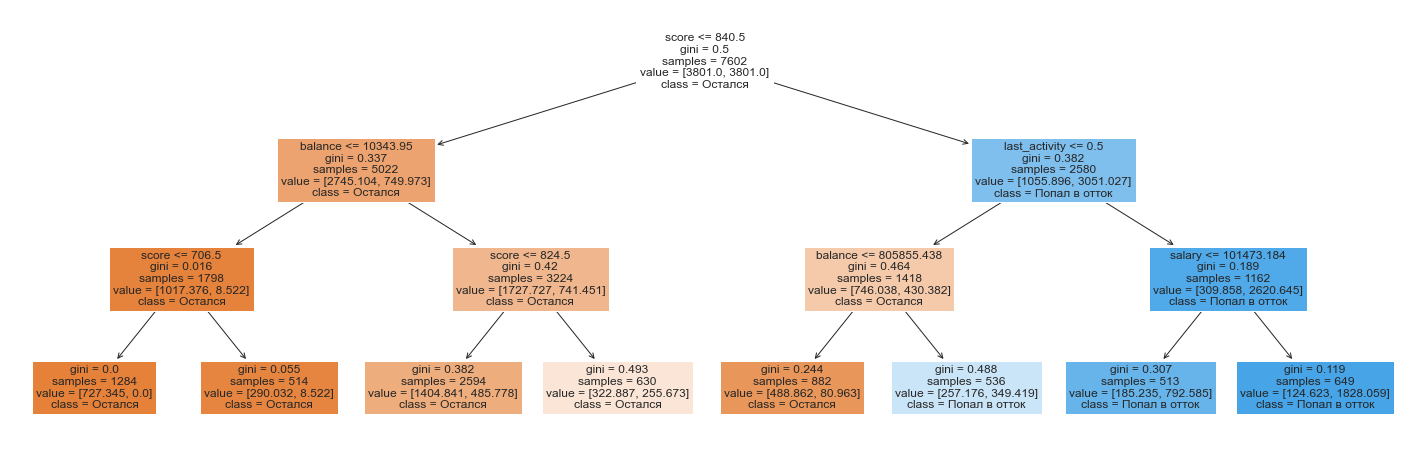

In [55]:
tree_model = DecisionTreeClassifier(class_weight='balanced', random_state=0, min_samples_leaf=500, max_depth=3)
tree_model.fit(X_train, y_train)
y_pred = tree_model.predict(X_test) 

plt.figure(figsize = (25,8)) # задайте размер фигуры, чтобы получить крупное изображение
plot_tree(tree_model, filled=True, feature_names = X_train.columns, class_names = ['Остался', 'Попал в отток'],
         fontsize=12)
plt.show() 

#### Вывод

Менее вероятный отток у тех, чья кредитная оценка меньше или равна 840 и тех, у кого она выше, но они неактивны и имеют баланс менее 805 856. Самый вероятный отток с кредитной оценкой свыше 840 и у активных клиентов. Средняя отточность у клиентов с оценкой выше 840, но неактивных и с балансом более 805 855.

## Описание портрета клиента

### Средний уровень оттока по группам, медиана, разброс данных по группам

Для составления окончательного портрета отточного и неотточного клиентов, посмотрю еще распределение по возрасту (так как по нему лучше прослеживаются отточные клиенты и можно дать более важные рекомендации) и создам категории клиентов. 

In [56]:
df_category = df_filter.groupby(by=['city', 'age']).agg({'churn':'mean'}).reset_index()

df_category.head()

city  age  churn
0  Ростов   18    1.0
1  Ростов   19    0.0
2  Ростов   20    0.5
3  Ростов   21    0.5
4  Ростов   22    0.0

In [57]:
# диаграмма распределения оттока среди клиентов разного возраста и разных городов
fig = px.scatter(df_category, x='age', y='churn', title='Доля оттока клиентов разного возраста по городам',
                 color="city")
fig.show()

Во всех городах отток после 60 лет снижается, выделю эту группу людей как "пенсионеров". Так же редкий и разбросанный отток среди тех, кому до 25 лет - определю их как "студентов" и остальных занесу в "рабочие"

In [58]:
#функция для категоризации возраста
def age_category(row):
    age = row['age']
    if age <= 24:
        return 'студенты'
    if age > 60:
        return 'пенсионеры'
    return 'рабочие'

#добавление в таблицу столбца с категориями 
df_filter['age_category'] = df_filter.apply(age_category, axis=1)

df_filter.sample(3)

user_id  score       city gender  age  equity     balance  products  \
2482   230768    832  Ярославль      Ж   54       5  1588870.20         2   
9305    72859    842    Рыбинск      М   26       5   320507.05         2   
5543   111787    854    Рыбинск      Ж   45       3   363563.33         2   

      credit_card  last_activity     salary  churn         balance_group  \
2482            0              1   55344.12      0      (1500000.0, inf]   
9305            1              1  151963.52      0  (250000.0, 500000.0]   
5543            1              1  145033.88      0  (250000.0, 500000.0]   

              salary_group   churn_ age_group age_category  
2482   (50000.0, 100000.0]  Остался  (47, 62]      рабочие  
9305  (100000.0, 250000.0]  Остался  (25, 47]      рабочие  
5543  (100000.0, 250000.0]  Остался  (25, 47]      рабочие

### Основные признаки в группах

Посмотрю как отличается отточность в полученных группах по кредитной оценке, балансу, продуктам и доходам:

In [59]:
# функция построения таблицы и диаграммы
def tabl_for_categ(df, column):
    
    tabl = df.groupby(by=[column, 'age_category']).agg({'churn':'mean'}).reset_index()
    tabl[column] = tabl[column].astype('str')
    tabl.dropna(inplace = True)
    # построение диаграммы
    fig = px.scatter(tabl, x='age_category', y=column, size='churn', size_max=55,
                  title=f'Параметр {column} и доля оттока по категориям клиентов',)
    fig.show()
    
# анализируемые признаки для диаграмм
param = df_filter[['score', 'balance_group', 'salary_group', 'products']]

# постоение диаграммы для каждго признака    
for data in param.columns:
    tabl_for_categ(df_filter, data) 

### Вывод

На основе анализа, приведенного выше (п.3.5 и 5.2), можно выделить основные черты клиентов, которые попали в отток и тех, кто не попал.

**В оттоке:**

- в г.Ярославль: мужчины от 18-62 лет и после 69 лет и женщины от 18-62 лет

  в г. Рыбинск: мужчины до 62 лет и немного женщины до 62 лет
  
  в г. Ростов: мужчины от 25-62 лет и женщины до 47 лет
  
- студенты (до 25 лет):
   - с кредитной оценкой от 800 и выше
   - с балансовым счетом до 500 000
   - с доходом до 250 000
   - количеством банковских продуктов 2-3 (у тех, кто имеет 3 продукта, отток 43%)
   
- рабочие (клиенты от 25-60 лет)
   - с кредитной оценкой от 680 и выше (много с оценкой 840 и выше)
   - с балансовым счетом более 100 000 (сильный отток с балансом выше 1 млн - 56% с балансом выше 1,5 млн)
   - с разным доходом, но чуть больше с доходом 100 000 - 400 000   
   - количеством банковских продуктов разное, но 59% имеют 4 продукта
   
- пенсионеры (старше 60 лет)
   - с кредитной оценкой от 760-800 и выше 900
   - с балансовым счетом более 100 000 (но их отток несущественный - 2-4%)
   - с доходом до 250 000, и чуть больше с доходом выше 400 000 
   - количеством банковских продуктов 3-4, при этом 50% имеют 4 продукта  
   
**Остаются в банке**:

- в г. Ярославль: мужчины от 62-69 лет и женщины  после 62 лет

  в г. Рыбинск: мужчины и женщины после 62 лет
  
  в г. Ростов: мужчины после 62 лет и женщины после 47 лет
  
- студенты (до 25 лет):
   - с кредитной оценкой ниже 800
   - с балансовым счетом более 500 000
   - с доходом более 250 000
   - количеством банковских продуктов 1, 4 и 5
   
- рабочие (клиенты от 25-60 лет)
   - с кредитной оценкой ниже 680
   - с балансовым счетом до 100 000
   - с одним банковским продуктом отток самый небольшой
   
- пенсионеры (старше 60 лет)
   - с кредитной оценкой ниже 760
   - с балансовым счетом до 100 000 
   - с доходом 250 000-400 000 
   - количеством банковских продуктов 1-2 и 5

## Гипотезы оттока клиентов и их проверка

В ходе анализа выдвинулось много нипотез, проверю статистическую значимость некоторых из них:

 ### Различия дохода между теми клиентами, которые ушли и теми, которые остались

Одна из метрик, которую можно тут использовать - средний доход клиента, но учитывая разброс в данных лучше взять медианное значение. Проверю есть ли разница между медианной заработной платой тех, кто остался и тех, кто ушел.

Сформулирую гипотезы:

- нулевая (Н0): различий между медианной заработной платой нет.
- альтернативная (Н1): различия между медианной заработной платой есть.

In [60]:
# медианная заработная плата для каждой группы
median_by_group = df_filter.groupby('churn').agg({'user_id':'count', 'salary':'median'})
median_by_group

user_id      salary
churn                     
0         8388  114320.115
1         1115  125395.220

Распределения в значениях доходов по данным не является нормальным, ~поэтому тут лучше использовать~Возьму  U-критерий Манна — Уитни, который сравнивает медиану двух распределений. U-критерий Манна — Уитни не зависит от выбросов и концентрируется на центре распределения.

Уровень значимости задам 0.01:

In [61]:
# выборки с данными о доходах для двух групп
data_a = df_filter.query('churn==0')['salary']
data_b = df_filter.query('churn==1')['salary']

# средняя заработная плата
median_a = data_a.median()
median_b = data_b.median()

# критический уровень значимости
alpha=0.01

# проверка критерием Манна-Уитни
stat, p_value = mannwhitneyu(data_a.to_list(), data_b.to_list())
# вывод полученного значения p-value
print('p-value:', '{:.2e}'.format(p_value))
# вывод средних значений в группах
print(f'Средние значения в группах: {median_a:.3f} и {median_b:.3f}')

# проверка 
if p_value < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать распределение групп разным')

p-value: 1.87e-06
Средние значения в группах: 114320.115 и 125395.220
Отвергаем нулевую гипотезу


Так как нулевая гипотеза отвергается, можно сказать, что средние доходы клиентов различаются и эта разница статистически значима.

 ### Различия по полу клиентов, которые ушли с теми, которые остались

На данных было видно, что мужчины и женщины отточны по-разному. Проверю эту гипотезу.

Сформулирую гипотезы:
 - нулевая (Н0): различий между долями оттока у мужчин и женщин нет.
 - альтернативная (Н1): различия между долей оттока у мужчин и женщин есть.

Данный тест можно провести с помощью теста для пропорций - z-test.

In [62]:
# выборки 
sample_a = df_with_categ.query('gender_Ж==0')['churn']
sample_b = df_with_categ.query('gender_Ж==1')['churn']

In [63]:
# критический уровень значимости
alpha=0.01

# проверка статистических критериев с помощью z-testa
stat, p_value = proportions_ztest([sample_a.sum(), sample_b.sum()], [len(sample_a), len(sample_b)])
    
print('p-value:', '{:.2e}'.format(p_value))

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
else:
    print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать что между долями есть разница')   

p-value: 7.04e-08
Отвергаем нулевую гипотезу: между долями есть значимая разница


Исходя из полученного результат можно сказать, что между долями оттока у мужчин и женщин есть статистически значимая разница, следовательно они действительно отточны по-разному.

### Различия количества продуктов, которыми пользуется клиент

Посмотрю, если различия в среднем количестве продуктов у клиентов, которые уходят и тех, кто остается.
Разницу в средних можно проверить с помощью ttest_ind из модуля scipy.stats.

Также необходимо проверить насколько отличаются дисперсии рассматриваемых совокупностей.

Сформулирую гипотезы:

- нулевая (Н0): различий между средним количеством продуктов у клиентов нет.
- альтернативная (Н1): различия между средним количеством продуктов у клиентов есть.

Критерий значимости задам 0.01

In [64]:
# выборки 
products_0 = df_filter.query('churn==0')['products']
products_1 = df_filter.query('churn==1')['products']

In [65]:
# дисперсии рассматриваемых совокупностей
var_products_0 = np.var(products_0, ddof=1)
print(f'Дисперсия выборки оставшихся клиентов: {var_products_0}')
var_products_1 = np.var(products_1, ddof=1)
print(f'Дисперсия выборки ушедших клиентов: {var_products_1}')

Дисперсия выборки оставшихся клиентов: 0.355291266162935
Дисперсия выборки ушедших клиентов: 0.7690172367986732


Так как дисперсии рассматриваемых выборок сильно отличаются, то в методе st.ttest_ind я задам параметр equal_var=False:

In [66]:
# критический уровень значимости
alpha = 0.01

# проверка гипотезы о равенстве двух выборок
stat, p_value = ttest_ind(products_0, products_1, equal_var=False)

print('p-value:', '{:.2e}'.format(p_value))

if p_value < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-value: 2.95e-94
Отвергаем нулевую гипотезу


Нет оснований полагать, что среднее количество продуктов у клиентов в оттоке и нет, одинаковое.

### Разница в доле оттока клиентов с различной кредитной оценкой

Самый значимым критерием оттока в исследуемых данных была кредитная оценка. По дереву принятия решений, клиенты с кредитной оценкой до 840 в отток почти не попадают, те, у кого она выше - в отток попадают очень часто. Проверю данную гипотезу.

Сформулирую гипотезы:

- нулевая (Н0): различий между долей оттока у клиентов нет.
- альтернативная (Н1): различия между долями оттока у клиентов есть.

Критерий значимости задам 0.01. Применю ttest_ind.

In [69]:
# выборки с данными об оценке для двух групп
data_1 = df_filter.query('churn==0')['score']
data_2 = df_filter.query('churn==1')['score']

# средняя оценка оттока
mean_1 = data_1.mean()
mean_2 = data_2.mean()

# критический уровень значимости
alpha=0.01

# проверка критерием Манна-Уитни
stat, p_value = mannwhitneyu(data_1.to_list(), data_2.to_list())
# вывод полученного значения p-value
print('p-value:', '{:.2e}'.format(p_value))
# вывод средних значений в группах
print(f'Средние значения в группах: {mean_1:.3f} и {mean_2:.3f}')

# проверка 
if p_value < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать распределение групп разным')

p-value: 1.96e-258
Средние значения в группах: 790.879 и 869.064
Отвергаем нулевую гипотезу


Нельзя утверждать, что доли оттока среди клиентов с кредитной оценкой до 840 и тех, у кого она выше одинаковы. 

### Вывод

На основе статистических тестов удалось доказать, что есть статистически значимые различия:
- между доходами клиентов, попавших в отток и оставшихся в банке
- между долями оттока среди мужчин и женщин
- между средним количеством продуктов у клиентов попавших в отток и оставшихся в банке
- между долями оттока у клиентов с кредитной оценкой до 840 и тех, у кого она выше

## Сегментация клиентов

На данный момент проведен анализ оттока клиентов и составлены портреты отточных и неотточных клиентов (их основные характеристики). Но остается вопрос почему же они уходят и что можно им предложить. Хорошо отвечает на данный вопрос построеное дерево принятия решений, которое показывает вероятность ухода клиента в зависимости от кредитной оценки, активности и баланса, то есть тех параметров, которые больше характеризуют банковские услуги, а не особенности клиентов (возраст, пол). С помощью дерева я разделю отточность на несколько сегментов (три) и проанализирую полученный результат.

### Разделение на сегменты в зависимости от уровня оттока

In [70]:
# функция для сегментации значений 
def customer_segment(row):
    if row['score'] > 840:
        if row['last_activity'] > 0.5:
            return 'high_churn'
        else:
            if row['balance'] > 805855:
                return 'middle_churn'
    return 'low_churn'

# столбец с названием сегмента
df_filter['segment'] = df_filter.apply(customer_segment, axis=1)

df_filter.sample(3)

user_id  score       city gender  age  equity     balance  products  \
1377   246461    894  Ярославль      М   38       4  1385265.72         2   
8639   185127    797  Ярославль      М   40       4  1144705.65         3   
8299   171746    806    Рыбинск      Ж   28       5   289502.00         2   

      credit_card  last_activity     salary  churn           balance_group  \
1377            0              0  207659.99      1  (1000000.0, 1500000.0]   
8639            1              1  120120.61      0  (1000000.0, 1500000.0]   
8299            1              1   43570.96      0    (250000.0, 500000.0]   

              salary_group   churn_ age_group age_category       segment  
1377  (100000.0, 250000.0]     Ушел  (25, 47]      рабочие  middle_churn  
8639  (100000.0, 250000.0]  Остался  (25, 47]      рабочие     low_churn  
8299        (0.0, 50000.0]  Остался  (25, 47]      рабочие     low_churn

Построю таблицу с основными характерными особенностями каждого сегмента:

In [71]:
# функция преобразования формата вывода данных в таблице
def display_with_format(df, format='%.2f'):
  old_format = pd.get_option('display.float_format') 
  pd.set_option('display.float_format', lambda x: format % x)
  display(df.head())
  pd.set_option('display.float_format', old_format)


df_segment = df_filter.groupby('segment').agg({'churn':'mean', 'user_id':'count',  'age':'mean', 'balance':'median',
                                                'salary':'median', 'products':'mean','equity':'mean', 'credit_card':'mean'})
# перестановка столбцов в заданном порядке
df_segment = df_segment.T.reindex(columns=['low_churn', 'middle_churn', 'high_churn'])

display_with_format(df_segment)

segment  low_churn  middle_churn  high_churn
churn         0.03          0.15        0.52
user_id    7364.00        687.00     1452.00
age          42.45         45.50       43.00
balance  264976.95    1199054.05   709256.55
salary   114721.43     138034.31   111308.02

Высокоотточный: Число клиентов в высокоотточном сегменте 1452. Среднее количество продуктов у них 2-3, средний баланс-709 256 и средняя з/п 111 308, возраст 43 и объектов в собственности в среднем 4. Это может говорить о том, что данные клиенты в основном уже имеют кредит в банке (на это указывает наличие данных о собственности), они достаточно обеспечены и активны. И в данном сегменте самый маленький процент (68%) кто имеет кредитную карту. Скорее всего могут уходить из-за невыгодных условий, процентных ставок, отсутствия выгодного рефинансирования, а так же учитывая их доходы и баланс, их могут не устраивать условия по вкладам или инвестициям, кредитным картам. 

Среднеотточный: В нем 687 клиентов. Среднее количество продуктов у них 2, средний баланс-1 199 054 и средняя з/п 138 034 возраст 45-46 и объектов в собственности в среднем 4. У этих клиентов немного продуктов банка, при этом очень хороший баланс на счету и выше средняя з/п (самый обеспеченный сегмент). Чуть больше, чем в высокоотточных, имеют кредитных карт. Скорее всего банк не предлагает им что-то стоящего по вложениям и инвестициям и кредитным картам.

Низкоотточный: Самый многочисленный сегмент, в нем 7364 клиента.  Среднее количество продуктов у них 1-2, средний баланс-264 976 и средняя з/п 114721 возраст 42 и объектов в собственности в среднем 2. Почти у всех есть кредитная карта (90%). Это клиенты, которые скорее всего больше нацелены на кредитование. 

### Выделяющие черты сегментов

Из полученной таблицы видно, что баланс клиентов, средний возраст и количество объектов в собственности достаточно различается в каждом сегменте. Построю графики и проанализирую их:

In [72]:
# сводная таблица количества клиентов по сегменту и возрастной группе
segment_and_age = make_pivot_for_bar(df_filter, 'segment', 'age_group', 'user_id', 'count')
segment_and_age['age_group'] = segment_and_age['age_group'].astype('str')
segment_and_age.head()

segment age_group  user_id_x  user_id_y    percent
9  high_churn   (0, 25]         47       1452   3.236915
5  high_churn  (25, 47]        911       1452  62.741047
6  high_churn  (47, 62]        323       1452  22.245179
7  high_churn  (62, 69]        101       1452   6.955923
8  high_churn  (69, 87]         70       1452   4.820937

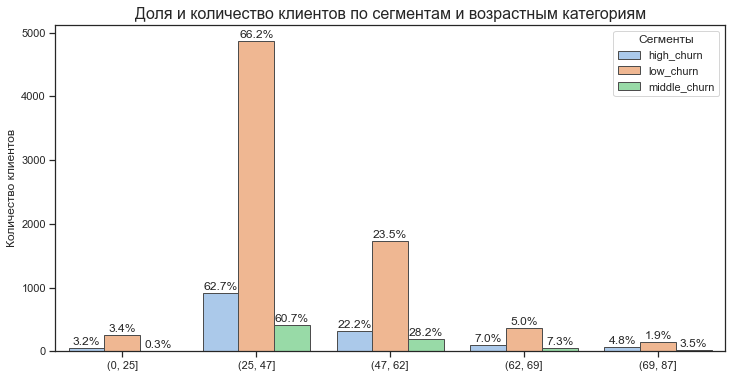

In [73]:
# построение графика
plt.figure(figsize=(12, 6)) 
ax = sns.barplot(x='age_group', y='user_id_x', hue='segment', data=segment_and_age, palette='pastel', edgecolor='.3')
ax.axes.set_title('Доля и количество клиентов по сегментам и возрастным категориям', fontsize=16)
ax.set_xlabel('')
ax.set_ylabel('Количество клиентов', fontsize=12)
# добавление относительных значений на график
percents = segment_and_age['percent'].to_list()
for count, p in enumerate(ax.patches):
    percentage = f'{percents[count]:.1f}%'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height() + 50
    ax.annotate(percentage, (x, y), ha='center')
    
plt.legend(title='Сегменты');

В высокоотточном сегменте больше всего клинтов 25-47 (62.7%) и чуть меньше 47-62 (22.2%) - основной ориентир должен быть на них.
В среднеотточном сегменте аналогично основная масса клиентов 25-47 лет (60.7%) и чуть поменьше 47-62 (22.2%)
В низкоотточном - самый большой по количеству клиентов от 25-47 лет (66.2%)

Все это лишний раз подтверждает, что основная отточность среди рабочего населения.

Посмотрю на распределение количества клиентов по сегментам в разных городах. Есть ли среди них существенные различия, которые стоит учитывать при удержании клиентов? 

In [74]:
# таблица с расчетом количества клиентов в сегментах
users = (df_filter.groupby(by=['segment', 'city', 'gender', 'age_group'])
                              .agg({'user_id':'count'})
                              .reset_index())
users['age_group'] = users['age_group'].astype('str')
users.dropna(inplace = True)
users
# диаграмма количества клиентов
fig = px.scatter(users, x='segment', y='age_group', size='user_id', color='gender', 
                 facet_col='city', size_max=100, title='Число клиентов в каждом сегменте', text='user_id')
fig.show()

Основная часть клиентов по всем городам, на которых стоит ориентироваться - от 25-47 лет и чуть поменьше 47-62 лет. Есть немного старше 62 лет, (в основном в Ярославле), можно тоже подумать над предложениями. Остальных настолько малое количество, что рассматривать их не имеет смысла.

Посмотрю на распределение баланса на счетах по сегментам и возрасту в разных городах. Чтобы результаты сильно не искажались, пренебрегу данными о неопределенном балансе (проставлен как -1), так как меня больше интересуют отточные клиенты, а по пропущенным записям в основном все клиенты, которые не попадают в отток:

In [75]:
segment_and_balance=df_filter.query('balance>=0').copy()

# таблица с расчетом медианного баланса
segment_and_balance = (segment_and_balance.groupby(by=['segment', 'city', 'age_group'])
                                         .agg({'balance':'median'})
                                         .reset_index())
segment_and_balance['age_group'] = segment_and_balance['age_group'].astype('str')
segment_and_balance.dropna(inplace = True)
# преобразование формата
display_with_format(segment_and_balance)

# диаграмма баланса клиентов в каждом городу и по возрастным категориям
fig = px.scatter(segment_and_balance, x='segment', y='age_group', size='balance', facet_col='city',
                  size_max=55, title='Баланс клиентов в зависимости от степени оттока и возраста')
fig.show()

segment    city age_group   balance
0  high_churn  Ростов   (0, 25] 108312.69
1  high_churn  Ростов  (25, 47] 630105.74
2  high_churn  Ростов  (47, 62] 884880.40
3  high_churn  Ростов  (62, 69] 652880.79
4  high_churn  Ростов  (69, 87] 429246.64

Высокооточные клиенты всех городов в возрасте старше 25 лет - все имеют хороший баланс.

Среднеотточные старше 25 лет + и в Ярославле младше 25 лет - самые крупные счета.

У низкоотточных баланс не большой. 

Посмотрю на количество объектов в собственности по каждому сегменту:

In [76]:
# таблица с расчетом количества объектов в собственности
segment_and_equity = (df_filter.groupby(by=['segment', 'city', 'gender', 'age_group'])
                              .agg({'equity':'median'})
                              .reset_index())
segment_and_equity['age_group'] = segment_and_equity['age_group'].astype('str')
segment_and_equity.dropna(inplace = True)

# диаграмма количества объектов в собственности
fig = px.scatter(segment_and_equity, x='segment', y='age_group', size='equity', color='gender', 
                 facet_col='city', size_max=55, title='Число объектов в собственности в каждом сегменте',) 
                 #text='equity', )
fig.show()

В высокооточном сегменте во всех городах в возрасте 25-69 лет достаточное количество объектов в собственности. Эту категорию лучше нацеливать на кредитные карты, рефинансирование. 

В среднеотточном сегменте у всех большое количество собственности - им лучше предлагать инвестиции и премиальные пакеты услуг.

В низкооточном (особенно в Ярославле и Рыбинске) - самое малое количество собственности.

### Вывод

Высокоотточный сегмент: 

- клиенты имеют высокую кредитную оценку (выше 840) и всегда активны. У них в среднем более 2х продуктов. Баланс в среднем - 709 256 и средняя з/п 111 308. Самый малый процент (68%) имеющих кредитную карту. Их активность говорит о том, что эти клиенты часто что-то делают на счетах (пополняют, погашают кредиты, переводят, вкладывают). Им будет интересны предложения по рефинансированию кредитов.

Среднеотточный сегмент:

- клиенты имеют высокую кредитную оценку (выше 840), но неактивны. Их баланс выше 805 855. Их численность небольшая (всего 687 человек). Это люди более старшего возраста (средний возраст 45 лет), с высоким балансом на счетах и з/п(средний баланс-1 199 054, средняя з/п 138 034). Учитывая их достаточно высокий баланс на счетах, и низкую активность, можно предположить, что это клиенты, которые не вкладывают постоянно средства (возможно нет предложений). Учитывая большое количество собственности, кредиты им не особо интересны. Но должны заинтересовать премиальные пакеты услуг (карты, страхование, доверительное управление, консьерж-сервис).

Низкоотточный сегмент:

-  клиенты имеют низкую кредитную оценку (ниже 840) и баланс менее 805 855. У них невысокий средний баланс-264 976 и средняя з/п 114 721. Больший из всех процент (90%) имеющих кредитную карту. Скорее данные клиенты больше нацелены на кредитование.

## Выводы и рекомендации

### Выводы по проделанному исследованию

Для прогнозирования  и предовращения оттока клиентов банка был проведен анализ распределения признаков, составлены характеристики клиентов, описаны портреты отточных и не отточных клиентов, применены модели машинного обучения и составлено дерево принятия решений, а также проведена сегментация клиентов по степени отточности на основе дерева принятия решений.

1. Из проведенного общего анализа клиентов, можно выделить основные характеристики клиентов:

   - большая часть клиентов банка имеет хорошую кредитную оценку (в среднем 800 баллов), что может говорить о возможном переманивания этих клиентов другими банками. 

   - меньше всего клиентов до 25 лет, с 26 лет их количество увеличивается почти втрое, и это основная масса клиентов до 47 лет. Большая часть этих клиентов возраста 30-45 лет. После 48 лет и до 62 их количество примерно одинаковое. Тех кому за 70 немного. То есть студенты мало заинтересованы услугами банка, как и пенсионеры, основная часть клиентов это работающее население и больше ориентироваться нужно на них.
   
   - много клиентов, у которых не числится никакая собственность, и тех, у кого их от 3х до 5ти. Шесть и более объектов имеет очень малое количество людей.

   - большая часть клиентов имеет 2 банковских продукта, совсем мало тех, у кого 3-4 и единицы, у кого их 5.

   - в среднем доходы 115 000. Доходы свыше 400 000 встречаются реже.

   - основная часть клиентов имеют кредитную карту; активных и неактивных клиентов примерно одинаково; в отток попадает менее 20% клиентов.

2. В ходе исследования составлены характерные черты отточных и неотточных клиентов:
- Клиенты, попадающие в отток: 
  - По городам и возрасту:
    - г. Ярославль: мужчины от 18-62 лет и после 69 лет и женщины от 18-62 лет
    - г. Рыбинск: мужчины до 62 лет и немного женщины до 62 лет
    - г. Ростов: мужчины от 25-62 лет и женщины до 47 лет

  - По возрастным группам:
    - студенты (до 25 лет):
      - с кредитной оценкой от 800 и выше 
      - с балансовым счетом до 500 000
      - с доходом до 250 000
      - количеством банковских продуктов 2-3 
    - рабочие (клиенты от 25-60 лет)
      - с кредитной оценкой от 680 и выше 
      - с балансовым счетом более 100 000 (56% с балансом выше 1,5 млн)
      - чаще с доходом 100 000 - 400 000 
      - 59% имеют 4 продукта
    - пенсионеры (старше 60 лет)
      - с кредитной оценкой от 760-800 и выше 900
      - с балансовым счетом более 100 000 
      - с доходом до 250 000 и выше 400 000 
      - количеством банковских продуктов 3-4 (50% имеют 4 продукта) 

     
- Остаются в банке:
  - По городам и возрасту:
    - в г. Ярославль: мужчины от 62-69 лет и женщины после 62 лет
    - в г. Рыбинск: мужчины и женщины после 62 лет
    - в г. Ростов: мужчины после 62 лет и женщины после 47 лет

  - По возрастным группам:
    - студенты (до 25 лет):
      - с кредитной оценкой ниже 800
      - с балансовым счетом более 500 000
      - с доходом более 250 000
      - количеством банковских продуктов 1, 4 и 5
    - рабочие (клиенты от 25-60 лет)
      - с кредитной оценкой ниже 680
      - с балансовым счетом до 100 000
      - с одним банковским продуктом 
    - пенсионеры (старше 60 лет)
      - с кредитной оценкой ниже 760
      - с балансовым счетом до 100 000 
      - с доходом 250 000-400 000 
      - количеством банковских продуктов 1-2 и 5

4. На основе статистических тестов удалось доказать, что есть статистически значимые различия:

  - между доходами клиентов, попавших в отток и оставшихся в банке
  - между долями оттока среди мужчин и женщин
  - между средним количеством продуктов у клиентов попавших в отток и оставшихся в банке
  - между долями оттока у клиентов с кредитной оценкой до 840 и тех, у кого она выше


5. При построении модели машинного обучения и дерева принятия решений было установлено, что сильное влияние на отток оказывает кредитная оценка, чуть менее активность и баланс. При анализе этих показателей получилось, что в отток больше всего попадают активные клиенты с кредитной оценкой выше 840 и высоким балансом. Это может означать, что такие клиенты часто пользуются банковскими продуктами, а учитывая, что баланс их высокий стараются больше инвестировать.


6. С помощью дерева принятия решений была проведена сегментация клиентов по степени оттока и рассмотрены основные характеристики, при которых клиенты больше или меньше попадают в отток. Удалось установить, что в банках разных городов нет существенных различия по клиентам (та где они есть, количество клиентов достаточно мало), поэтому при рекомендациях это не стоит учитывать. Общие черты:
 - Высокоотточный сегмент: 
     - среднее количество продуктов 2-3, средний баланс-709 256 и средняя з/п 111 308, объектов в собственности в среднем 4, самый маленький процент (68%) имеющих кредитную карту

- Среднеотточный: 
     - среднее количество продуктов 2, средний баланс-1 199 054 и средняя з/п 138 034, объектов в собственности в среднем 4, чуть больше, чем в высокоотточных, имеют кредитные карты.

- Низкоотточный:
     - среднее количество продуктов у них 1-2, средний баланс-264 976 и средняя з/п 114721, объектов в собственности в среднем 2. Почти у всех есть кредитная карта (90%). 
    
7. По городам:
- Высокооточные: клиенты всех городов в возрасте старше 25 лет имеют хороший баланс. Во всех городах в возрасте 25-62 лет  достаточное количество объектов в собственности.
- Среднеотточные: клиенты старше 25 лет - имеют самые крупные счета. У всех большое количество собственности.
- У низкоотточных клиентов: баланс не большой, и самое малое количество собственности.

### Рекомендации для удержания клиентов

На основании приведенного исследования и выводов предлагается:

- Общие рекомендации по удержанию ключевых категорий клиентов:
  - Сегмент 1 - 
    - Клиенты: активные клиенты с кредитной оценкой выше 840
    - Потребности: экономия, обслуживание текущих кредитов, вложение свободных средств
    - Предложить: кредитные карты с кэшбэком, рефинансирование кредитов по меньшей ставке, инвестиционные программы
  - Сегмент 2:
    - Клиенты: неактивные клиенты с кредитной оценкой выше 840 и балансом более 805855 р.
    - Потребности: сохранение и приумножение капитала, подчеркивание высокого статуса
    - Предложить: премиальные пакеты услуг (карты, страхование, доверительное управление, консьерж-сервис и т.д.)
    
  - Сегмент 3:
    - Клиенты: неактивные клиенты с кредитной оценкой выше 840 и балансом менее 805855 р., а также клиенты с кредитной оценкой менее 840
    - Потребности: обслуживание текущих кредитов, получение новых
    - Предложить: кредитование и рефинансирование имеющихся кредитов
    
    
- Дополнительные рекомендации по удержанию клиентов в г.Ярославль: 
  - всем мужчинам старше 69 лет стоит предложить пенсионные программы по вкладам
